### In this project I predict which users will leave the application - churn prediction (very weak signal)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import statsmodels.api as sm
import scipy.stats
from sklearn.model_selection import train_test_split , cross_val_score
from matplotlib.pyplot import figure, show
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV
from scipy.stats import randint
from scipy.stats import uniform as sp_rand
from functools import reduce
import random


%matplotlib inline
sns.set(style='whitegrid',color_codes=True)

# Data

In [469]:
train_usage_data = pd.read_csv('C:/Users/heng/Desktop/lightricks/train_usage_data.csv',parse_dates=['end_use_date'])

In [470]:
train_users_data = pd.read_csv('C:/Users/heng/Desktop/lightricks/train_users_data.csv',parse_dates=['installation_date','subscripiton_date'])

In [471]:
train_all_data = pd.merge(train_usage_data, train_users_data, on='id', how='inner')

In [472]:
test_usage_data = pd.read_csv('C:/Users/heng/Desktop/lightricks/test_usage_data.csv',parse_dates=['end_use_date'])

In [473]:
test_users_data = pd.read_csv('C:/Users/heng/Desktop/lightricks/test_users_data.csv',parse_dates=['installation_date','subscripiton_date'])

In [474]:
test_users_data.shape

(1732, 8)

In [475]:
y_test = pd.read_csv('C:/Users/heng/Desktop/lightricks/y_test.csv')

In [476]:
y_test.shape

(1732, 3)

In [477]:
test_users_data_with_target = pd.merge(test_users_data, y_test, on='id', how='inner')

In [478]:
test_users_data_with_target = test_users_data_with_target[['id', 'installation_date', 'subscripiton_date', 'country',
       'initial_app_version', 'initial_ios_version', 'initial_device',
       'churned', 'days_until_churn']]

In [479]:
test_users_data_with_target.head()

,id,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,churned,days_until_churn
0,100000416140868,2017-01-15 04:22:41,2018-04-02 15:07:34,United States,1.9.1,11.2,UIDeviceKindIPhone8Plus,0,128.0
1,100000416155841,2017-11-28 06:49:20,2018-04-02 16:01:53,Denmark,1.7.3,11.1.2,UIDeviceKindIPhone6S,0,NaN
2,100000416575791,2017-06-08 03:33:41,2018-04-03 21:34:11,United States,1.5,10.3.2,UIDeviceKindIPhone6S,1,14.0
3,100000416982689,2018-01-06 12:28:49,2018-04-05 02:25:26,United States,1.9.6,11.1.1,UIDeviceKindIPhone6SPlus,1,26.0
4,100000417016727,2018-01-04 05:46:51,2018-04-05 04:42:11,United States,1.9.5,11.2.6,UIDeviceKindIPhone8Plus,0,34.0


In [480]:
test_all_data = pd.merge(test_usage_data, test_users_data_with_target, on='id', how='inner')

In [481]:
test_unique_app_version = list(test_all_data.initial_app_version.unique())
test_unique_ios_version = list(test_all_data.initial_ios_version.unique())

In [482]:
train_all_data.head()

,id,feature_name,usage_duration,end_use_date,accepted,Unnamed: 0,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned
0,30000429392689,Relight,5.659,2018-04-10 11:18:16,False,2741,2018-02-26 07:01:08,2018-04-08 09:38:19,Australia,1.9.6,11.2.6,UIDeviceKindIPhoneX,NaN,0
1,30000429392689,Light FX,117.594,2018-04-08 11:30:00,False,2741,2018-02-26 07:01:08,2018-04-08 09:38:19,Australia,1.9.6,11.2.6,UIDeviceKindIPhoneX,NaN,0
2,30000429392689,Light FX,11.073,2018-04-08 21:47:41,False,2741,2018-02-26 07:01:08,2018-04-08 09:38:19,Australia,1.9.6,11.2.6,UIDeviceKindIPhoneX,NaN,0
3,30000429392689,Vignette,40.977,2018-04-10 11:18:05,False,2741,2018-02-26 07:01:08,2018-04-08 09:38:19,Australia,1.9.6,11.2.6,UIDeviceKindIPhoneX,NaN,0
4,30000429392689,Adjust,59.131,2018-04-08 11:47:25,False,2741,2018-02-26 07:01:08,2018-04-08 09:38:19,Australia,1.9.6,11.2.6,UIDeviceKindIPhoneX,NaN,0


In [483]:
# train_all_data
# test_all_data

# EDA - exploratory data analysis functions

In [484]:
def missing_Values_Per_Column(df):
    ''' A function which returns the number of missing values per column '''
    return df.isna().sum()

In [485]:
missing_Values_Per_Column(train_users_data)

Unnamed: 0                0
id                        0
installation_date         0
subscripiton_date         0
country                   2
initial_app_version       0
initial_ios_version       0
initial_device            0
days_until_churn       3778
churned                   0
dtype: int64

In [486]:
def fill_Missing_Values(df,column):
    ''' A function which fills the missing values within a column with the mode value of the column'''
    fiiled_column = df[column].fillna(df[column].mode()[0])
    df[column] = fiiled_column
    return df
     

In [487]:
missing_Values_Per_Column(fill_Missing_Values(train_users_data,'country'))

Unnamed: 0                0
id                        0
installation_date         0
subscripiton_date         0
country                   0
initial_app_version       0
initial_ios_version       0
initial_device            0
days_until_churn       3778
churned                   0
dtype: int64

In [488]:
def plot_Histogram(df,column):
    ''' A function which plots an histogram of the given column'''
    sns.distplot(df[column])
    plt.pyplot.suptitle('distribution of {}'.format(column))

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


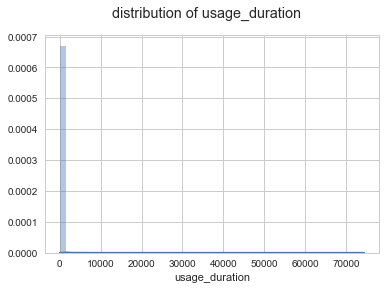

In [489]:
plot_Histogram(train_usage_data,'usage_duration')

In [490]:
def apply_log_transformation(df,column):
    ''' A function which creates a normal distribution of the data'''
    transformed =  df[column].apply(np.log10)
    df[column] = transformed
    return df

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


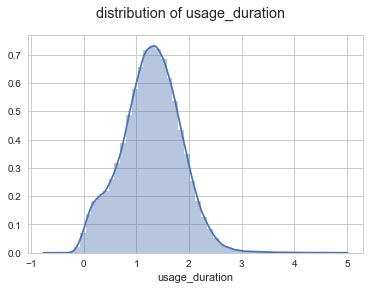

In [491]:
plot_Histogram(apply_log_transformation(train_usage_data,'usage_duration'),'usage_duration')

In [492]:
# def plot_Barchart():
#     sns.barplot(x="day", y="total_bill", hue="sex", data=tips)

In [493]:
def count_Plot_Single_Column(df,column,num_obs=10):
    ''' A function which plots a count plot for one column'''
    figure(figsize=(40,10))
    sns.countplot(x=column, data=df,
                  order = df[column].value_counts().iloc[:num_obs].index)

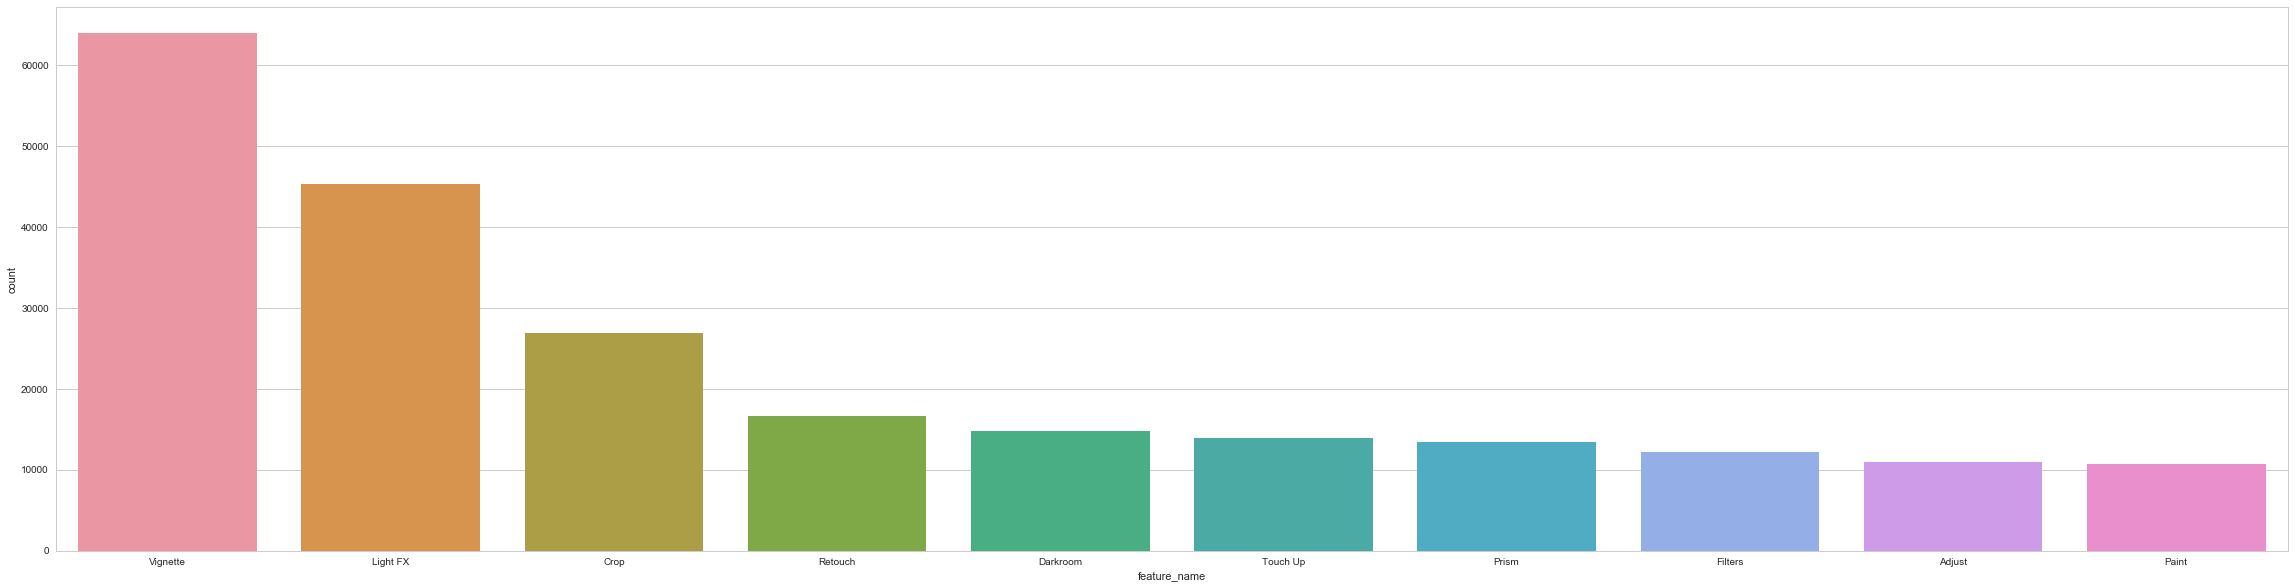

In [494]:
count_Plot_Single_Column(train_all_data,'feature_name')

In [495]:
def count_Plot_Multiple_Columns(df,X_column, hue_column,num_obs=10):
    ''' A function which plots a count plot for multiple columns'''
    figure(figsize=(100,20))
    sns.countplot(x=X_column, hue=hue_column ,data=df,
                  order = df[X_column].value_counts().iloc[:num_obs].index)

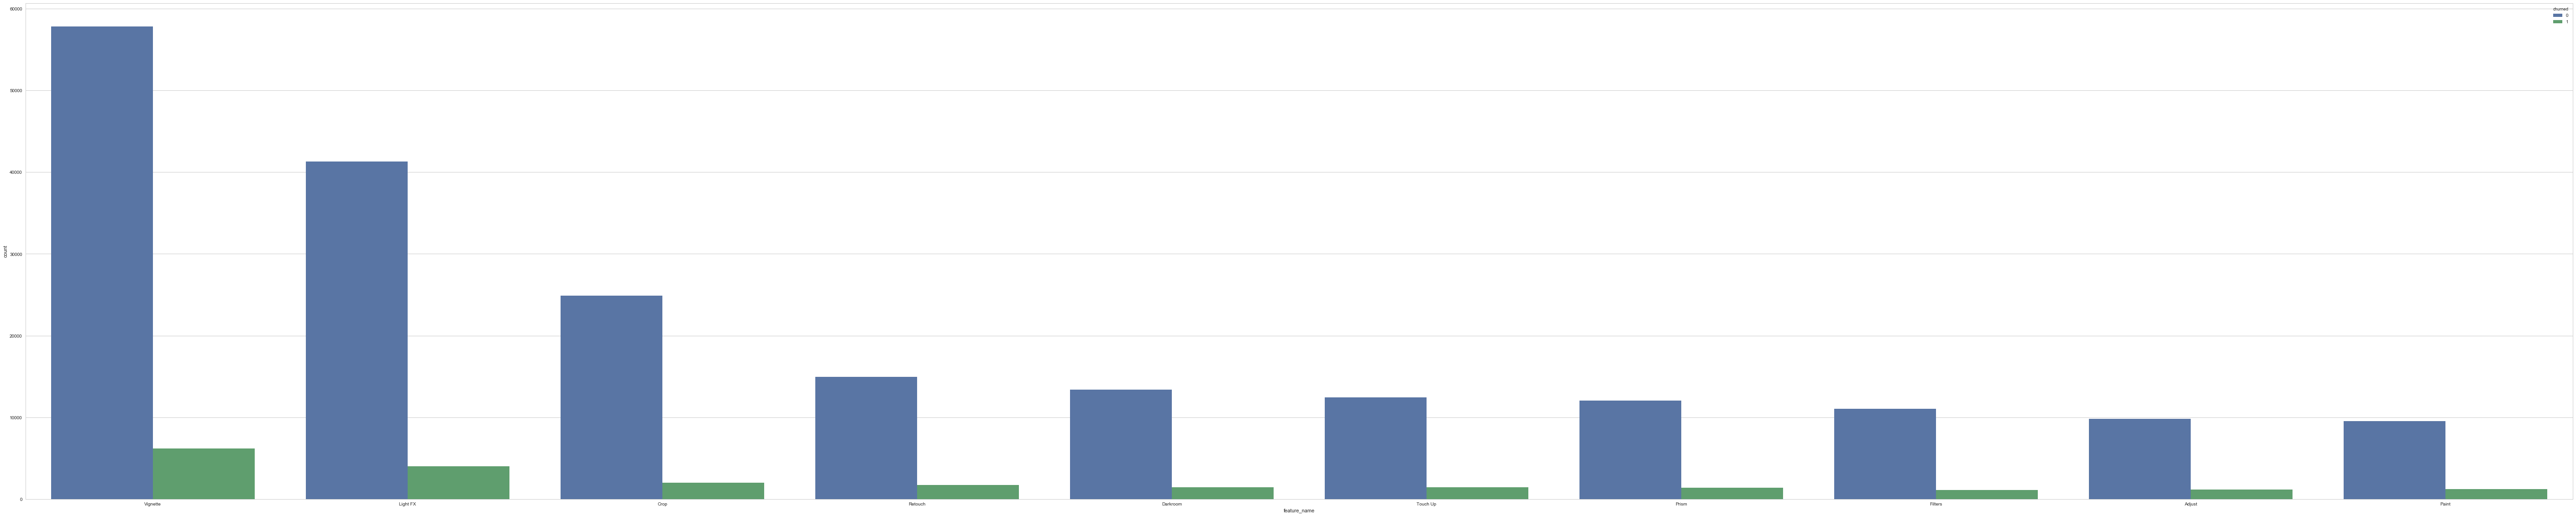

In [496]:
count_Plot_Multiple_Columns(train_all_data,'feature_name','churned')

In [497]:
def present_Statistics(df,column):
    ''' A function which presents descriptive statistics on the column '''
    return df[column].describe()

In [498]:
present_Statistics(train_all_data,'usage_duration')

count    263814.000000
mean         56.426541
std         581.810905
min           0.239000
25%           8.224000
50%          19.695000
75%          45.242000
max       74424.617000
Name: usage_duration, dtype: float64

In [499]:
def interecation_Between_Two_Categorical_Variables_pct(df,target_column,explenatory_column):
    ''' A function which creates crosstab of the target and the explanatory variable and present in percent values'''
    ct = pd.crosstab(df[target_column],df[explenatory_column]) # create crosstab
    colsum = ct.sum(axis=0) # convert to percent
    colpct = ct / colsum
    return colpct

In [500]:
interecation_Between_Two_Categorical_Variables_pct(train_all_data,'churned','feature_name')

feature_name,Adjust,Backdrop,Crop,Darkroom,Defocus,Eyes,Face,Filters,Light FX,Paint,Patch,Prism,Relight,Reshape,Retouch,Touch Up,Vignette
churned,,,,,,,,,,,,,,,,,
0,0.895355,0.883529,0.92597,0.903376,0.888889,0.879427,0.886243,0.907286,0.911542,0.889065,0.921296,0.898084,0.882142,0.92198,0.896483,0.8951,0.903355
1,0.104645,0.116471,0.07403,0.096624,0.111111,0.120573,0.113757,0.092714,0.088458,0.110935,0.078704,0.101916,0.117858,0.07802,0.103517,0.1049,0.096645


In [501]:
def interecation_Between_Two_Categorical_Variables(df,target_column,explenatory_column):
    ''' A function which creates crosstab of the target and the explanatory variable and present in count values'''
    ct = pd.crosstab(df[target_column],df[explenatory_column]) # create crosstab
    return ct

In [502]:
interecation_Between_Two_Categorical_Variables(train_all_data,'churned','feature_name')

feature_name,Adjust,Backdrop,Crop,Darkroom,Defocus,Eyes,Face,Filters,Light FX,Paint,Patch,Prism,Relight,Reshape,Retouch,Touch Up,Vignette
churned,,,,,,,,,,,,,,,,,
0,9831,5128,24891,13379,2896,7797,5360,11058,41312,9553,199,12046,3937,5755,14939,12458,57812
1,1149,676,1990,1431,362,1069,688,1130,4009,1192,17,1367,526,487,1725,1460,6185


In [503]:
def make_Copy(df):
    ''' A function which creates a copy of the dataframe'''
    copy_ = df.copy()
    return copy_

In [504]:
def bucket_Numeric_Variables(df,column, num_bins=5):
    colname = 'bucketized_' + column
    values = df[column].values
    min_val = np.min(values)
    max_val = np.max(values)
    bins_bounderies = np.linspace(min_val,max_val,num_bins+1)
    #print(bins_bounderies)
    bins_bounderies_tuples = [(str(i),[bins_bounderies[i],bins_bounderies[i+1]]) for i in range(len(bins_bounderies)-1)]
    colname_values = []
    for val in values:
        for tup in bins_bounderies_tuples:
            if val >= tup[1][0] and val <= tup[1][1]:
                colname_values.append(tup[0])
                               
    df[colname] = colname_values
    return df

In [505]:
#bucket_Numeric_Variables(train_df_copy,'avg_time_between_usage', num_bins=4)


In [506]:
def chi_Square_Test(cross_tab):
    ''' Apply chi-square test for 2 categorical variables '''
    cs = scipy.stats.chi2_contingency(cross_tab)
    return cs

In [507]:
chi_Square_Test(interecation_Between_Two_Categorical_Variables(train_all_data,'churned','feature_name'))

(413.15604412100549,
 6.3439400069570957e-78,
 16,
 array([[  9.92022402e+03,   5.24380512e+03,   2.42864792e+04,
           1.33805572e+04,   2.94354188e+03,   8.01026468e+03,
           5.46425454e+03,   1.10116294e+04,   4.09466733e+04,
           9.70790593e+03,   1.95151948e+02,   1.21183939e+04,
           4.03223678e+03,   5.63952990e+03,   1.50556114e+04,
           1.25746519e+04,   5.78200890e+04],
        [  1.05977598e+03,   5.60194880e+02,   2.59452077e+03,
           1.42944283e+03,   3.14458118e+02,   8.55735321e+02,
           5.83745457e+02,   1.17637064e+03,   4.37432670e+03,
           1.03709407e+03,   2.08480520e+01,   1.29460612e+03,
           4.30763223e+02,   6.02470096e+02,   1.60838861e+03,
           1.34334809e+03,   6.17691105e+03]]))

In [508]:
def check_For_Moderators(df,target_column,explenatory_column,suspected_moderator):
    ''' A function which checks if the suspected modetaror is really a moderator and if the moderator is the reason for the significance in the chi-square test '''
    uqinue_values = df[suspected_moderator].unique()
    #print(uqinue_values)
    partitioned_dfs = []
    partitioned_crosstabs = []
    chi_test_results = []
    non_filtered_results = []
    for val in uqinue_values:
        partitioned_dfs.append(df[df[suspected_moderator] == val])
    
    for item in partitioned_dfs:
        partitioned_crosstabs.append(interecation_Between_Two_Categorical_Variables(item,target_column,explenatory_column))
        
    for crosstab_ in partitioned_crosstabs:
        result = chi_Square_Test(crosstab_)[1]
        non_filtered_results.append(result)
        if result < 0.05:
            chi_test_results.append('significant')
        else:
            chi_test_results.append('not significant')
    
    flag = 0
    for res in chi_test_results:
        if res == 'not significant':
            flag = 1
    
    if flag == 1:
        return 'this column is a moderator' , non_filtered_results 
    else:
        return 'this column is not a moderator' , non_filtered_results 

In [509]:
check_For_Moderators(train_all_data,'churned','feature_name','accepted')

('this column is not a moderator',
 [5.3981649279497205e-12, 1.1461918604549886e-79])

# Feature Engineering Functions

In [614]:
def avg_Time_Between_Usage(df,user_column, usage_time_column):
    time_differences = []
    user_avg_time_usage_diff = {}
    count = 0
    current_id = ''
    last_time_used = ''
    ids = []
    max_diffs = []
    for index, row in df.iterrows():
        if current_id != row[user_column]:
            if len(time_differences) > 0:
                user_avg_time_usage_diff[current_id] = (np.mean(np.asarray(time_differences)))
                time_differences = []
            current_id = row[user_column]
            last_time_used = ''

        if not last_time_used:
            last_time_used = row[usage_time_column]

        else:
            diff = (row[usage_time_column] - last_time_used).seconds // 3600
            time_differences.append(diff)
    
    for key, value in user_avg_time_usage_diff.items():
        ids.append(key)
        max_diffs.append(value)
    
    data = {'id':ids , 'avg_time_between_usage':max_diffs}
    avg_time_diff_df = pd.DataFrame.from_dict(data)
    return avg_time_diff_df
        

In [615]:
#avg_Time_Between_Usage(train_all_data,'id','end_use_date').head()

In [616]:
def max_Time_Between_Usage(df,user_column, usage_time_column):
    time_differences = []
    user_max_time_usage_diff = {}
    count = 0
    current_id = ''
    last_time_used = ''
    ids = []
    max_diffs = []
    for index, row in df.iterrows():
        if current_id != row[user_column]:
            if len(time_differences) > 0:
                user_max_time_usage_diff[current_id] = (np.max(np.asarray(time_differences)))
                time_differences = []
            current_id = row[user_column]
            last_time_used = ''

        if not last_time_used:
            last_time_used = row[usage_time_column]

        else:
            diff = (row[usage_time_column] - last_time_used).seconds // 3600
            time_differences.append(diff)
    
    
    for key, value in user_max_time_usage_diff.items():
        ids.append(key)
        max_diffs.append(value)
    
    data = {'id':ids , 'max_time_between_usage':max_diffs}
    max_time_diff_df = pd.DataFrame.from_dict(data)
    return max_time_diff_df

In [617]:
#max_Time_Between_Usage(train_all_data,'id','end_use_date').head()

In [618]:
def number_Of_Times_The_User_Used_The_App(df,column_name='id'):
    user_used = df[column_name].value_counts()
    user_used_df = pd.DataFrame(user_used)
    user_used_df.columns = ['times_user_used_app']
    
    user_used_df = user_used_df.reset_index()
    col_names = ['id','times_user_used_app']
    user_used_df.columns = col_names
    return user_used_df

In [619]:
#number_Of_Times_The_User_Used_The_App(train_all_data,column_name='id').head()

In [620]:
def unique_Fitures_Per_User(df,user_column="id", feature_column="feature_name"):
    unique_features = {}
    for user in pd.unique(df[user_column]):
        unique_features[user] = len(pd.unique(df[df[user_column]==user][feature_column]))
    
    
    data = {'id': list(unique_features.keys()) , 'unique_features':list(unique_features.values())}
    unique_features_df = pd.DataFrame.from_dict(data)
    return unique_features_df

In [621]:
#unique_Fitures_Per_User(train_all_data).head()

In [622]:
def time_Difference_By_Installation_Time(df):
# Format: {id1:[installation_time, first_time_feature, difference]}
    times_per_user={}  
    for i in range(len(df)):
        user= df["id"].iloc[i]
        if user in times_per_user:
            feature_time = df["end_use_date"].iloc[i]
            if (feature_time < times_per_user[user][1]):
                times_per_user[user][1] = feature_time 
        else:
            installation_time = df["installation_date"].iloc[i]
            feature_time = df["end_use_date"].iloc[i]
            times_per_user[user]=[installation_time, feature_time]

    time_difference_installation_first_time_feature = {}
    for user in times_per_user:
        time_difference_installation_first_time_feature[user] = (times_per_user[user][1]-times_per_user[user][0]).seconds / 3600

    data = {'id': list(time_difference_installation_first_time_feature.keys()) , 'time_difference_installation_first_time_feature':list(time_difference_installation_first_time_feature.values())}
    time_difference_installation_first_time_feature_df = pd.DataFrame.from_dict(data)
    return time_difference_installation_first_time_feature_df

In [623]:
#time_Difference_By_Installation_Time(train_all_data).head()

In [624]:
def time_Difference_By_Subscription_Time(df):
    times_per_user_subscription={}  
    for i in range(len(df)):
        user = df["id"].iloc[i]
        if user in times_per_user_subscription:
            feature_time = df["end_use_date"].iloc[i]
            if (feature_time < times_per_user_subscription[user][1]):
                times_per_user_subscription[user][1] = feature_time 
        else:
            subscrption_time = df["subscripiton_date"].iloc[i]
            feature_time = df["end_use_date"].iloc[i]
            times_per_user_subscription[user]=[subscrption_time, feature_time]

    time_difference_subscription_first_time_feature = {}
    for user in times_per_user_subscription:
        time_difference_subscription_first_time_feature[user] = (times_per_user_subscription[user][1]-times_per_user_subscription[user][0]).seconds / 3600
        
    data = {'id': list(time_difference_subscription_first_time_feature.keys()) , 'time_difference_subscripiton_first_time_feature':list(time_difference_subscription_first_time_feature.values())}
    time_difference_subscripiton_first_time_feature_df = pd.DataFrame.from_dict(data)
    return time_difference_subscripiton_first_time_feature_df

In [625]:
#time_Difference_By_Subscription_Time(train_all_data).head()

In [626]:
def average_Time_The_User_Used_A_Feature(df):
    average_feature_use_by_feature = df.groupby(['id','feature_name'])['usage_duration'].mean()
    average_feature_use_by_feature_df = pd.DataFrame(average_feature_use_by_feature)
    average_feature_use_by_feature_df.columns = ['average_time_on_feature']
    
    average_feature_use = average_feature_use_by_feature_df.groupby(['id'])['average_time_on_feature'].mean()
    average_feature_use_df = pd.DataFrame(average_feature_use)
    average_feature_use_df.columns = ['average_time_on_feature']
    
    average_feature_use_df = average_feature_use_df.reset_index()
    col_names = ['id','average_time_on_feature']
    average_feature_use_df.columns = col_names
    return average_feature_use_df

In [523]:
#average_Time_The_User_Used_A_Feature(train_all_data).head()

# Prepare Data For Model

In [524]:
def normalize_Data(df,target_column):
    X = df.iloc[:, df.columns!=target_column].values
    y = df.loc[:,target_column].values
    
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    return X_norm, y

In [525]:
def one_Hot_Encode(df):
    return pd.get_dummies(df)

In [526]:
def balance_Data_SMOTE(x_norm,y,ratio='auto'):
    sm = SMOTE(random_state=12, ratio = ratio)
    X_res, y_res = sm.fit_sample(x_norm, y)
    return X_res, y_res

# Models

In [527]:
def xgboost_Model(x,y):
    model = XGBClassifier()
    model.fit(x, y)
    return model

In [528]:
def random_Forest_Model(x,y):
    model = RandomForestClassifier()
    model.fit(x,y)
    return model

In [529]:
def logistic_Regression_Model(x,y):
    model = LogisticRegression()
    model.fit(x,y)
    return model

# Evaluation Metric

In [530]:
def f1_Metric(prediction,y_val):
    #return np.round(f1_score(y_pred=prediction,y_true=y_val),3)
    return classification_report(y_pred=prediction,y_true=y_val)

# Hyper Parameter Tuning

In [531]:
def tune_Hyper_Parameters(model,times_to_run,param_dist,X,Y):
    # specify "parameter distributions" rather than a "parameter grid"
    best_scores = []
    for _ in range(times_to_run):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='f1', n_iter=10, return_train_score=False, random_state=5)
        rand.fit(X,Y)
        best_scores.append(round(rand.best_score_, 3))
    return rand, best_scores

# Predict

In [532]:
def make_Predictions(best_model,x_test):
    predictions = best_model.predict(x_test)
    return predictions

# Main 

In [533]:
#### data exploration functions
# plot_Histogram(df,column)
# apply_log_transformation(df,column)
# count_Plot_Single_Column(df,column)
# count_Plot_Multiple_Columns(df,X_column, hue_column)
# present_Statistics(df,column)
# interecation_Between_Two_Categorical_Variables_pct(df,target_column,explenatory_column)
# interecation_Between_Two_Categorical_Variables(df,target_column,explenatory_column)
# make_Copy(df)
# chi_Square_Test(cross_tab)
# check_For_Moderators(df,target_column,explenatory_column,suspected_moderator)
# bucket_Numeric_Variables(df,column, num_bins=5)

In [534]:
#### feature engineering functions
# avg_Time_Between_Usage(df,user_column, usage_time_column)
# max_time_between_usage(df,user_column, usage_time_column)
# number_Of_Times_The_User_Used_The_App(df,column_name='id')
# unique_Fitures_Per_User(df,user_column="id", feature_column="feature_name")
# time_Difference_By_Installation_Time(df)
# time_Difference_By_Subscription_Time(df)
# average_Time_The_User_Used_A_Feature(df)

### create train dataset

In [535]:
avg_Time_Between_Usage_ = avg_Time_Between_Usage(train_all_data,'id','end_use_date') #  missing 250 values
max_time_between_usage = max_Time_Between_Usage(train_all_data,'id','end_use_date') #  missing 250 values
number_Of_Times_The_User_Used_The_App = number_Of_Times_The_User_Used_The_App(train_all_data,column_name='id') # same
unique_Fitures_Per_User = unique_Fitures_Per_User(train_all_data) # same
time_Difference_By_Installation_Time = time_Difference_By_Installation_Time(train_all_data) # same
time_Difference_By_Subscription_Time = time_Difference_By_Subscription_Time(train_all_data) # same
average_Time_The_User_Used_A_Feature = average_Time_The_User_Used_A_Feature(train_all_data) # same

dfs = [train_users_data, number_Of_Times_The_User_Used_The_App,unique_Fitures_Per_User,time_Difference_By_Installation_Time,time_Difference_By_Subscription_Time,average_Time_The_User_Used_A_Feature]
train_df = reduce(lambda left,right: pd.merge(left,right,on='id'), dfs)

train_df = pd.merge(train_df, avg_Time_Between_Usage_, on='id', how='left')

train_df = pd.merge(train_df, max_time_between_usage, on='id', how='left')

train_df = train_df[['id','initial_app_version','initial_device','initial_ios_version','installation_date','subscripiton_date','country', 'avg_time_between_usage','max_time_between_usage', 'times_user_used_app', 'unique_features','time_difference_installation_first_time_feature','time_difference_subscripiton_first_time_feature','average_time_on_feature','churned',]]

train_df.head()

,id,initial_app_version,initial_device,initial_ios_version,installation_date,subscripiton_date,country,avg_time_between_usage,max_time_between_usage,times_user_used_app,unique_features,time_difference_installation_first_time_feature,time_difference_subscripiton_first_time_feature,average_time_on_feature,churned
0,100000415577994,1.9.1,UIDeviceKindIPhoneX,11.2.5,2017-07-16 22:29:31,2018-04-01 01:35:58,Canada,16.210526,23.0,39,8,3.141667,0.034167,22.883271,0
1,100000415580508,1.7.5,UIDeviceKindIPhoneX,11.2.1,2016-12-19 14:28:03,2018-04-01 01:45:40,New Zealand,20.864865,23.0,38,9,11.296111,0.002500,47.304181,0
2,100000415636784,1.6,UIDeviceKindIPhone6S,10.3.3,2017-02-09 00:48:33,2018-04-01 05:15:46,United States,9.200000,23.0,6,6,4.455556,0.001944,51.177333,0
3,100000415750897,1.9.5,UIDeviceKindIPhone5S,11.2.6,2017-12-07 16:03:47,2018-04-01 13:27:22,Turkey,2.090909,23.0,12,5,21.522222,0.129167,38.982207,0
4,100000415825030,1.9.5,UIDeviceKindIPhone8,11.2.6,2017-12-01 14:59:29,2018-04-01 17:23:33,United States,15.333333,23.0,4,2,2.465833,0.064722,36.659333,1


In [536]:
train_df_copy = make_Copy(train_df)
train_df_copy = train_df_copy.fillna(999) # fill missing values with 999
train_df_copy['avg_time_between_usage'] = train_df_copy['avg_time_between_usage'].replace(0,0.01)
train_df_copy['max_time_between_usage'] = train_df_copy['max_time_between_usage'].replace(0,0.01)
# train_df_copy['initial_app_version'] = train_df_copy['initial_app_version'].replace('initial_app_version_1.1', train_df_copy['initial_app_version'].mode()) # this value doesn't exist in the test set
# train_df_copy['initial_app_version'] = train_df_copy['initial_app_version'].replace('initial_app_version_1.4.2', train_df_copy['initial_app_version'].mode()) # this value doesn't exist in the test set
# train_df_copy['initial_ios_version'] = train_df_copy['initial_ios_version'].replace('initial_ios_version_10.0', train_df_copy['initial_ios_version'].mode()) # this value doesn't exist in the test set
# train_df_copy['initial_ios_version'] = train_df_copy['initial_ios_version'].replace('initial_ios_version_10.0.3', train_df_copy['initial_ios_version'].mode()) # this value doesn't exist in the test set
# train_df_copy['initial_ios_version'] = train_df_copy['initial_ios_version'].replace('initial_ios_version_9.2', train_df_copy['initial_ios_version'].mode()) # this value doesn't exist in the test set
# train_df_copy['initial_ios_version'] = train_df_copy['initial_ios_version'].replace('initial_ios_version_9.2.1', train_df_copy['initial_ios_version'].mode()) # this value doesn't exist in the test set
mode_initial_app_version = train_df_copy['initial_app_version'].mode()[0]
mode_initial_ios_version = train_df_copy['initial_ios_version'].mode()[0]
train_df_copy.loc[~train_df_copy['initial_app_version'].isin(test_unique_app_version), 'initial_app_version'] = mode_initial_app_version
train_df_copy.loc[~train_df_copy['initial_ios_version'].isin(test_unique_ios_version), 'initial_ios_version'] = mode_initial_ios_version


train_df_copy.isna().sum()

id                                                 0
initial_app_version                                0
initial_device                                     0
initial_ios_version                                0
installation_date                                  0
subscripiton_date                                  0
country                                            0
avg_time_between_usage                             0
max_time_between_usage                             0
times_user_used_app                                0
unique_features                                    0
time_difference_installation_first_time_feature    0
time_difference_subscripiton_first_time_feature    0
average_time_on_feature                            0
churned                                            0
dtype: int64

In [537]:
# apply log transformation to all numeric feature
train_df_copy = apply_log_transformation(train_df_copy,'avg_time_between_usage')
train_df_copy = apply_log_transformation(train_df_copy,'max_time_between_usage')
train_df_copy = apply_log_transformation(train_df_copy,'times_user_used_app')
train_df_copy = apply_log_transformation(train_df_copy,'unique_features')
train_df_copy = apply_log_transformation(train_df_copy,'time_difference_installation_first_time_feature')
train_df_copy = apply_log_transformation(train_df_copy,'time_difference_subscripiton_first_time_feature')
train_df_copy = apply_log_transformation(train_df_copy,'average_time_on_feature')

In [538]:
train_df_copy.columns

Index(['id', 'initial_app_version', 'initial_device', 'initial_ios_version',
       'installation_date', 'subscripiton_date', 'country',
       'avg_time_between_usage', 'max_time_between_usage',
       'times_user_used_app', 'unique_features',
       'time_difference_installation_first_time_feature',
       'time_difference_subscripiton_first_time_feature',
       'average_time_on_feature', 'churned'],
      dtype='object')

In [539]:
train_df_copy['max_time_between_usage'].unique()

array([ 1.36172784,  1.25527251, -2.        ,  2.99956549,  1.34242268,
        1.04139269,  1.30103   ,  1.32221929,  1.        ,  0.95424251,
        0.30103   ,  1.07918125,  1.17609126,  1.11394335,  0.84509804,
        1.20411998,  1.2787536 ,  1.23044892,  0.69897   ,  0.        ,
        0.77815125,  1.14612804,  0.60205999,  0.90308999,  0.47712125])

### data exploration

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


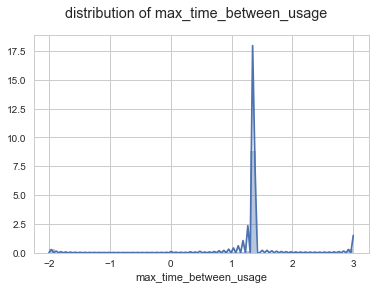

In [540]:
plot_Histogram(train_df_copy,'max_time_between_usage')

In [541]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'max_time_between_usage', num_bins=15)

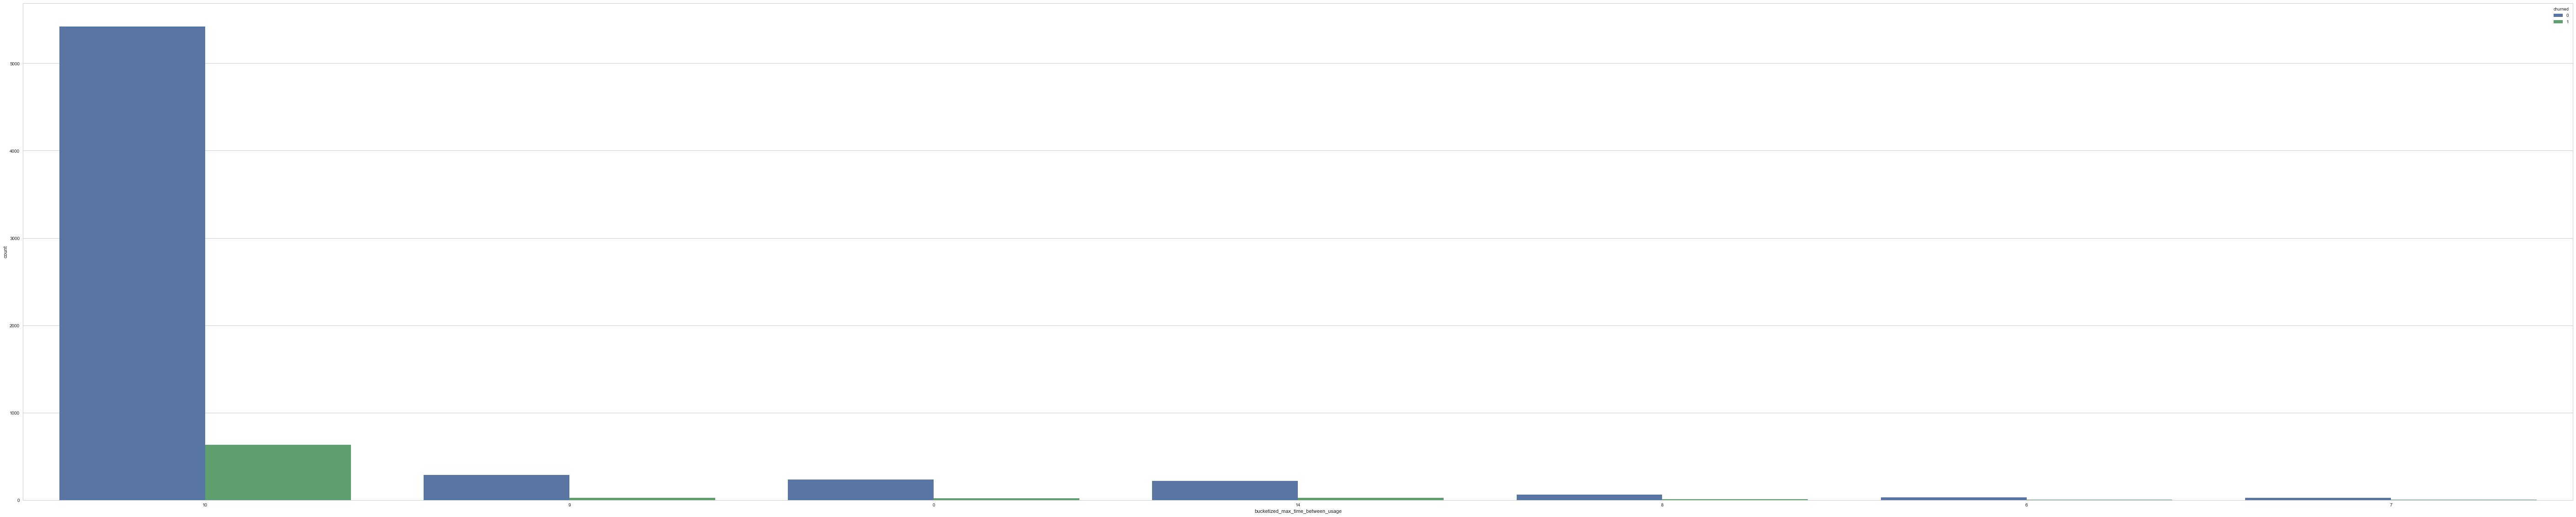

In [542]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_max_time_between_usage', 'churned')

In [543]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'max_time_between_usage', num_bins=10)

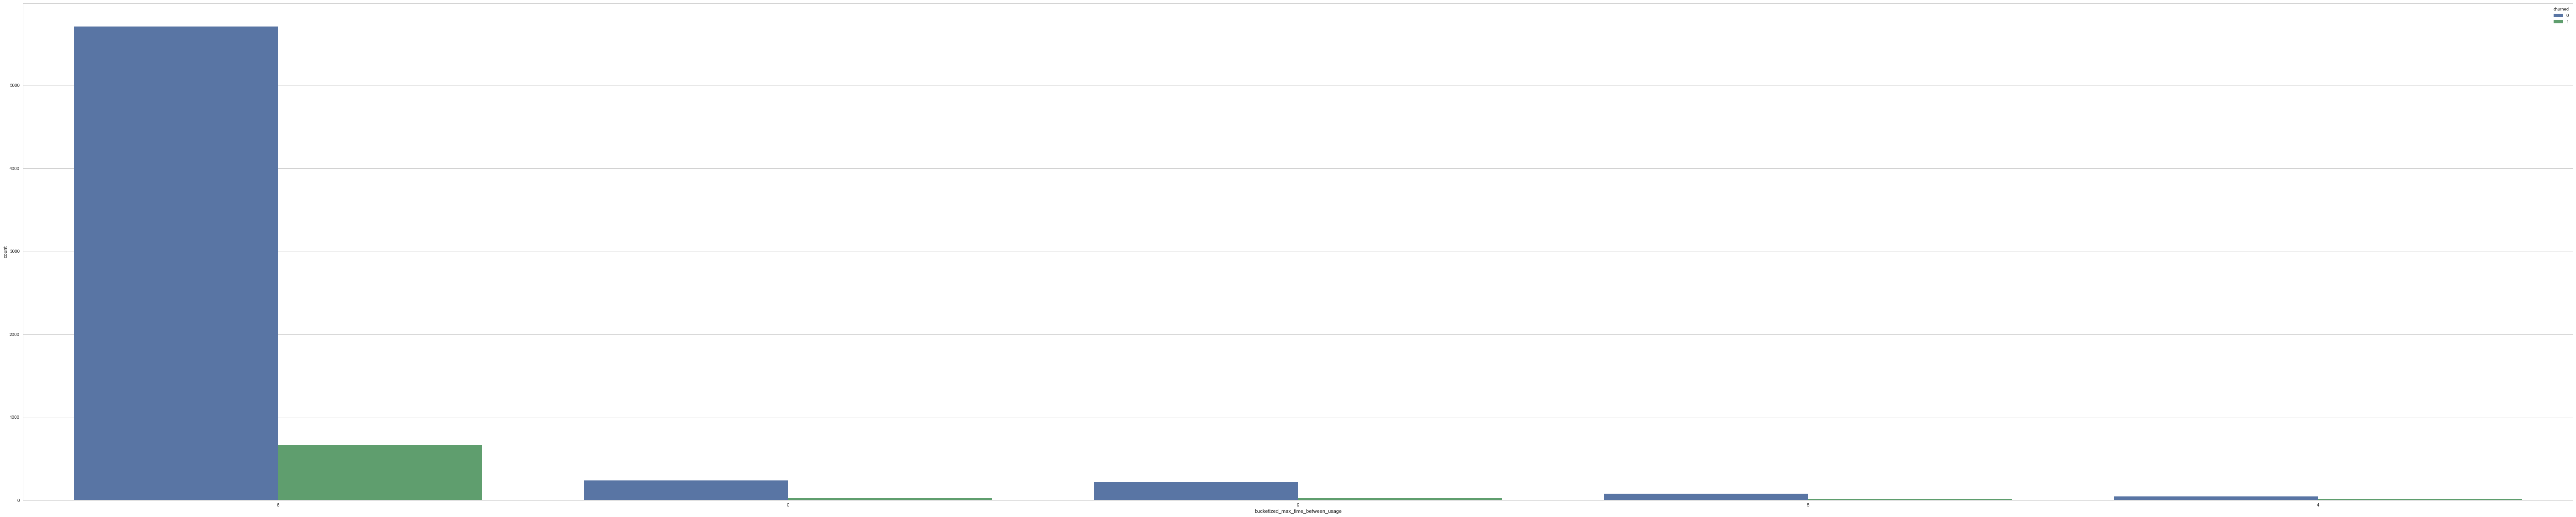

In [544]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_max_time_between_usage', 'churned')

In [545]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'max_time_between_usage', num_bins=5)

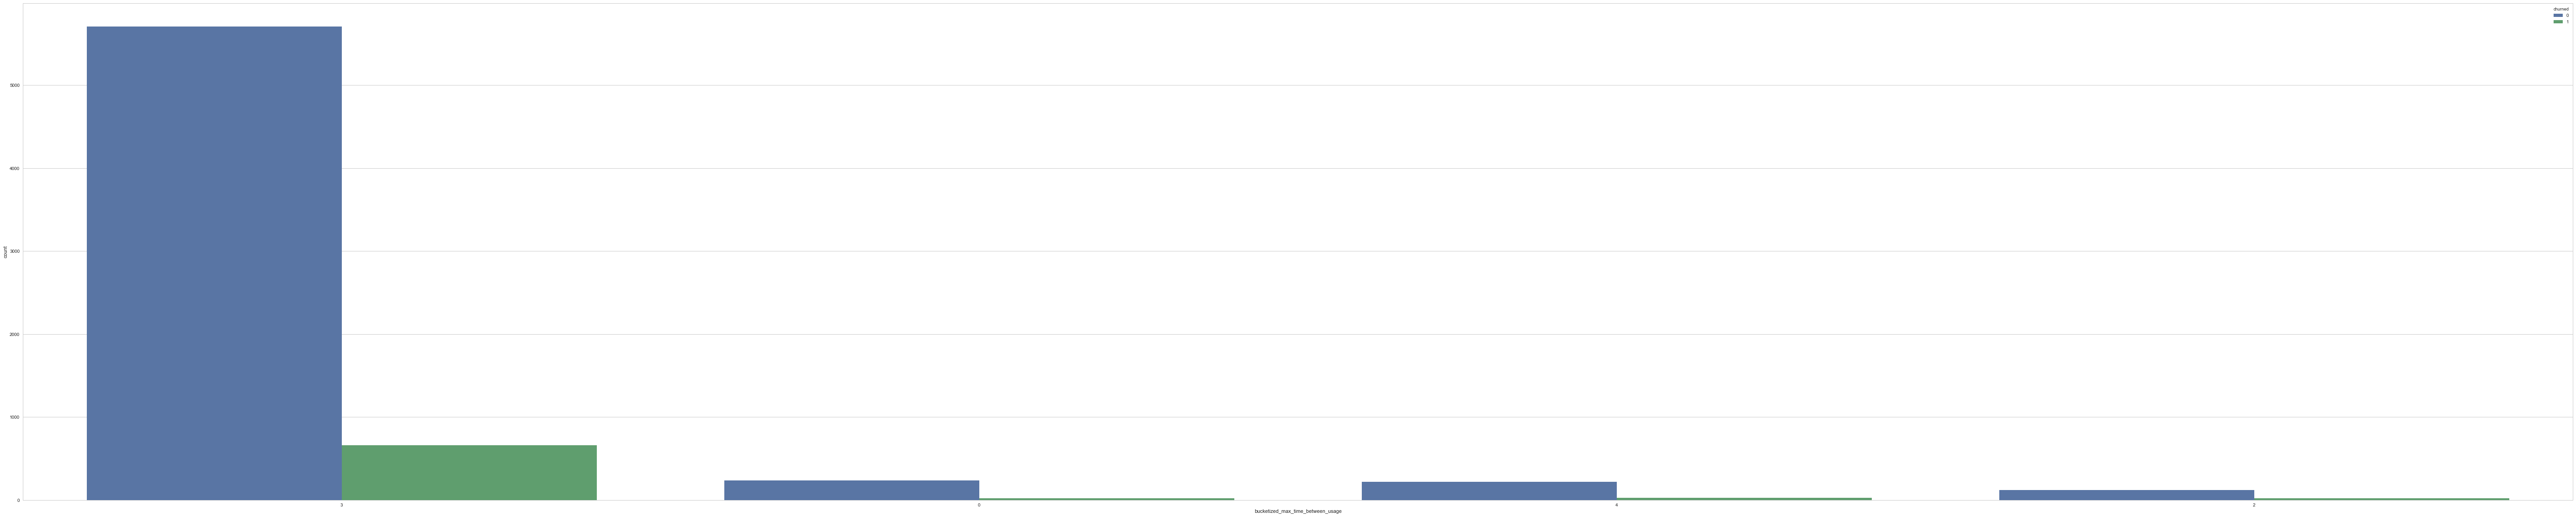

In [546]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_max_time_between_usage', 'churned')

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


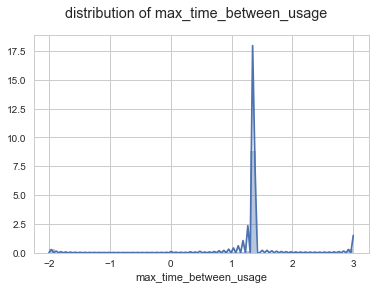

In [547]:
plot_Histogram(train_df_copy,'max_time_between_usage')

In [548]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'avg_time_between_usage', num_bins=15)

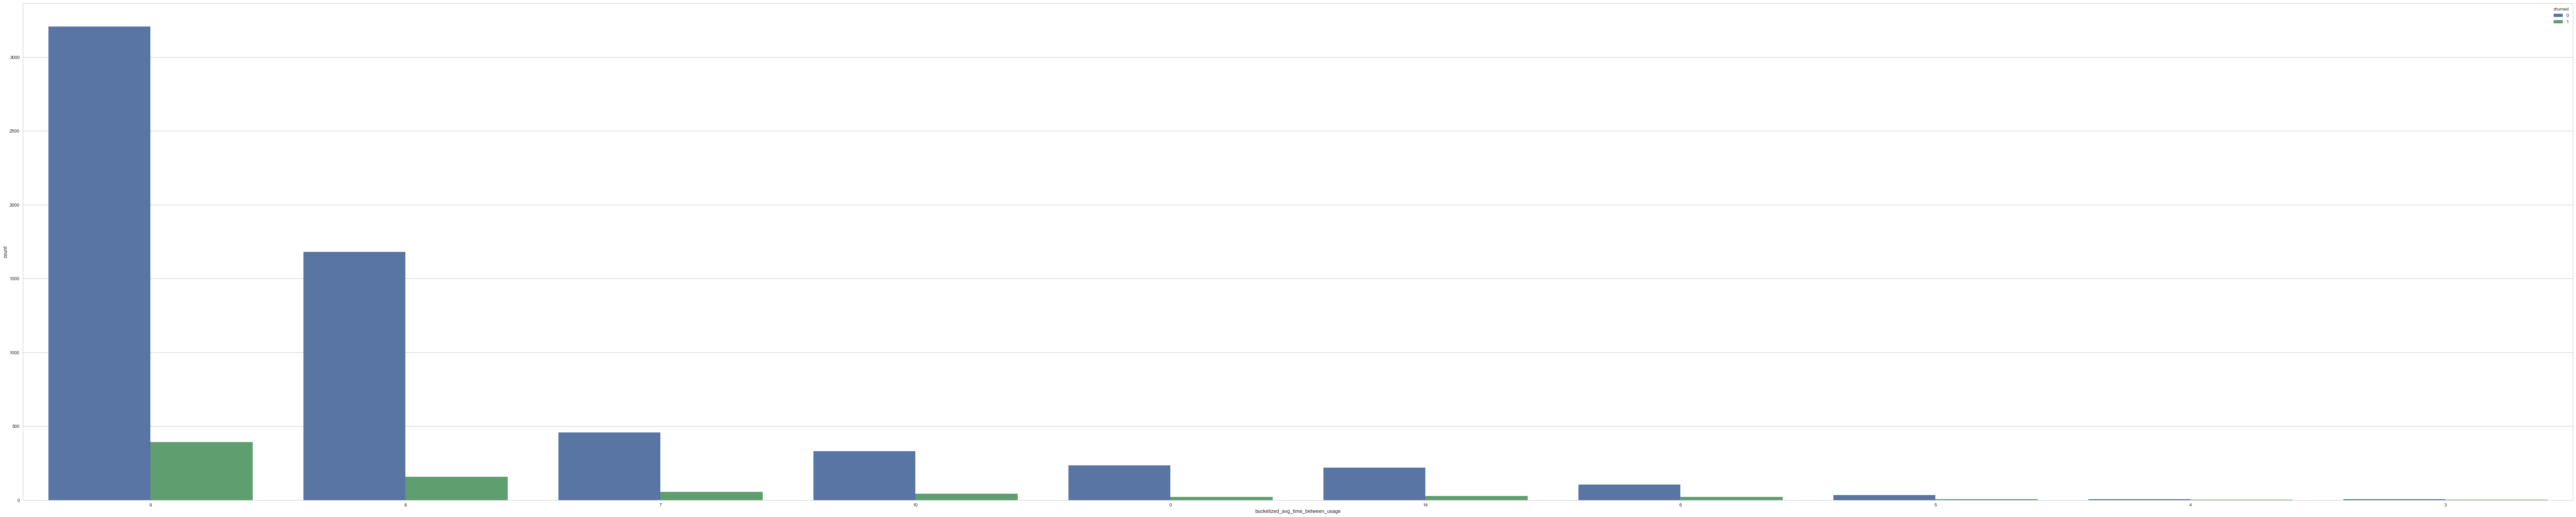

In [549]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_avg_time_between_usage', 'churned')

In [550]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'avg_time_between_usage', num_bins=10)

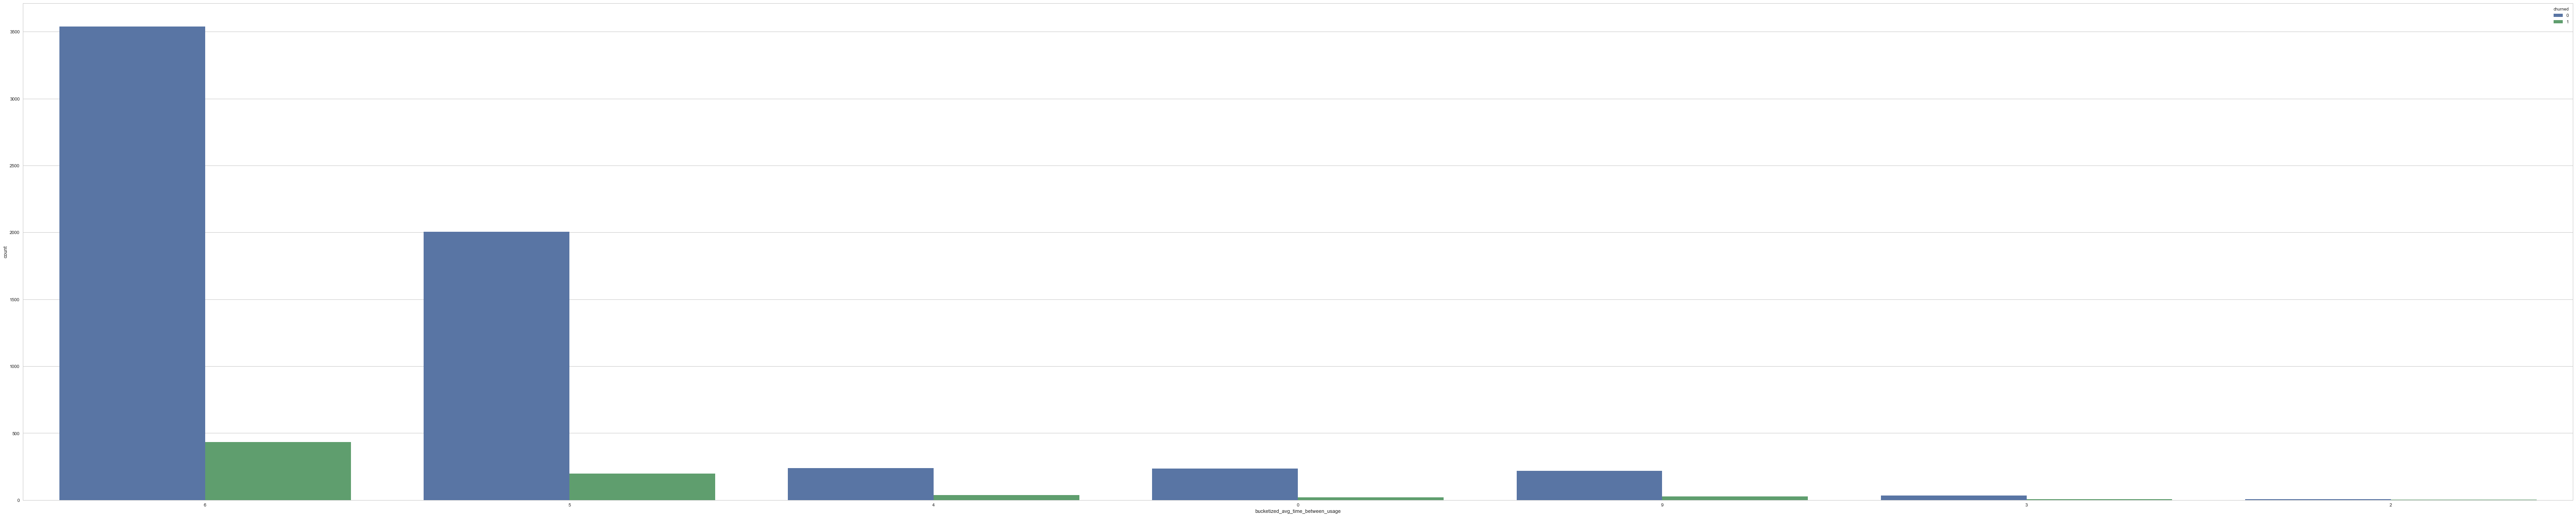

In [551]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_avg_time_between_usage', 'churned')

In [552]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'avg_time_between_usage', num_bins=5)

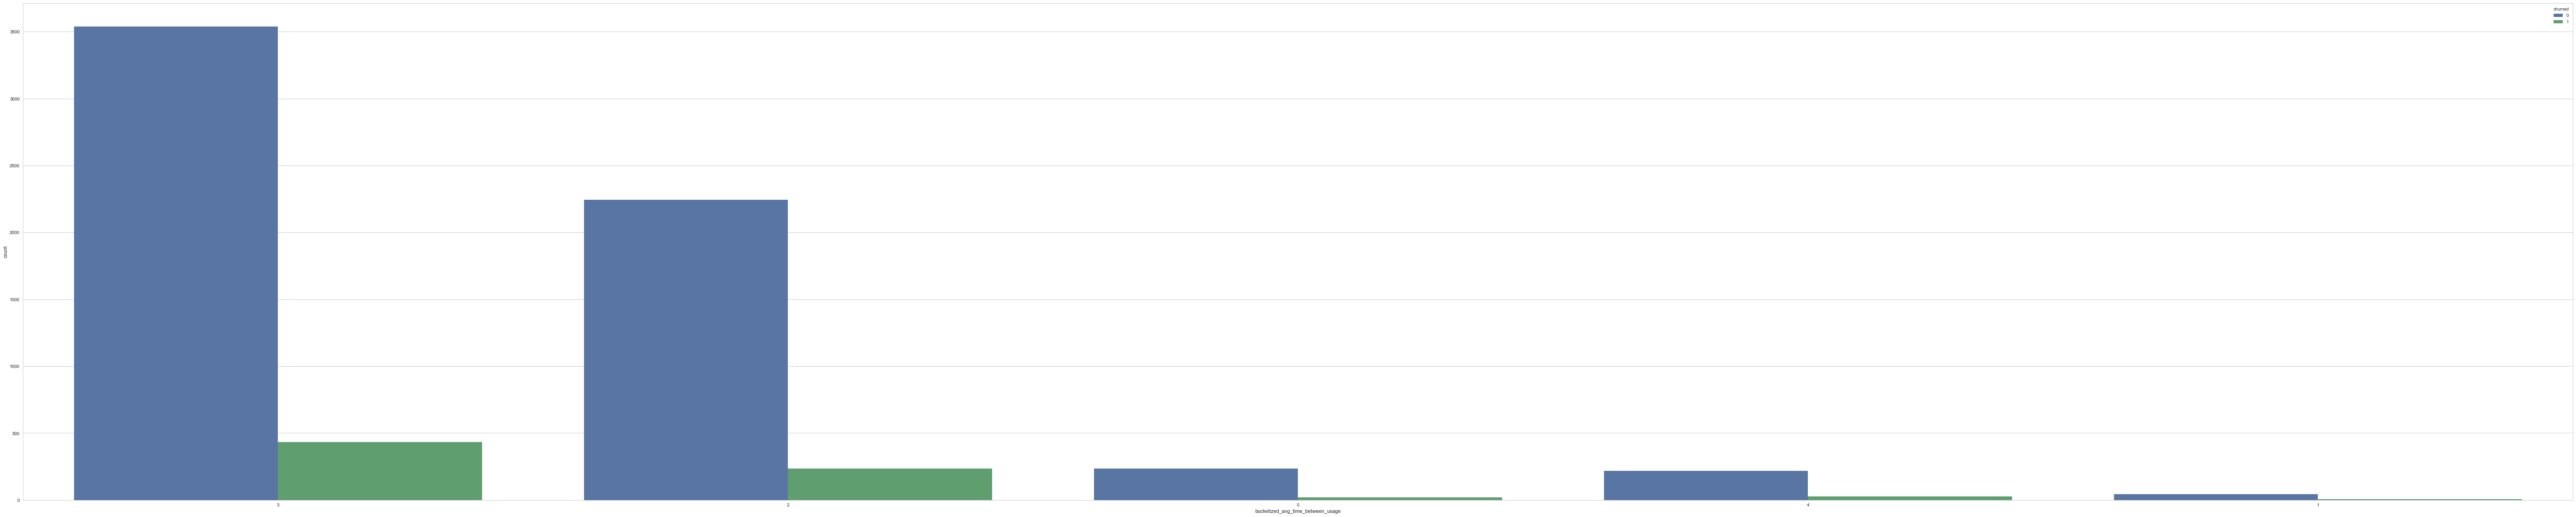

In [553]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_avg_time_between_usage', 'churned')

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


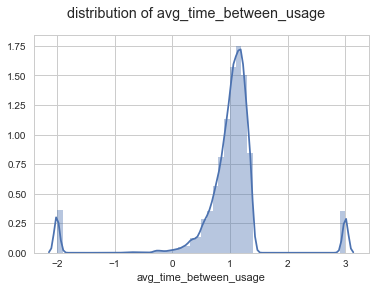

In [554]:
plot_Histogram(train_df_copy,'avg_time_between_usage')

In [555]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'times_user_used_app', num_bins=15)

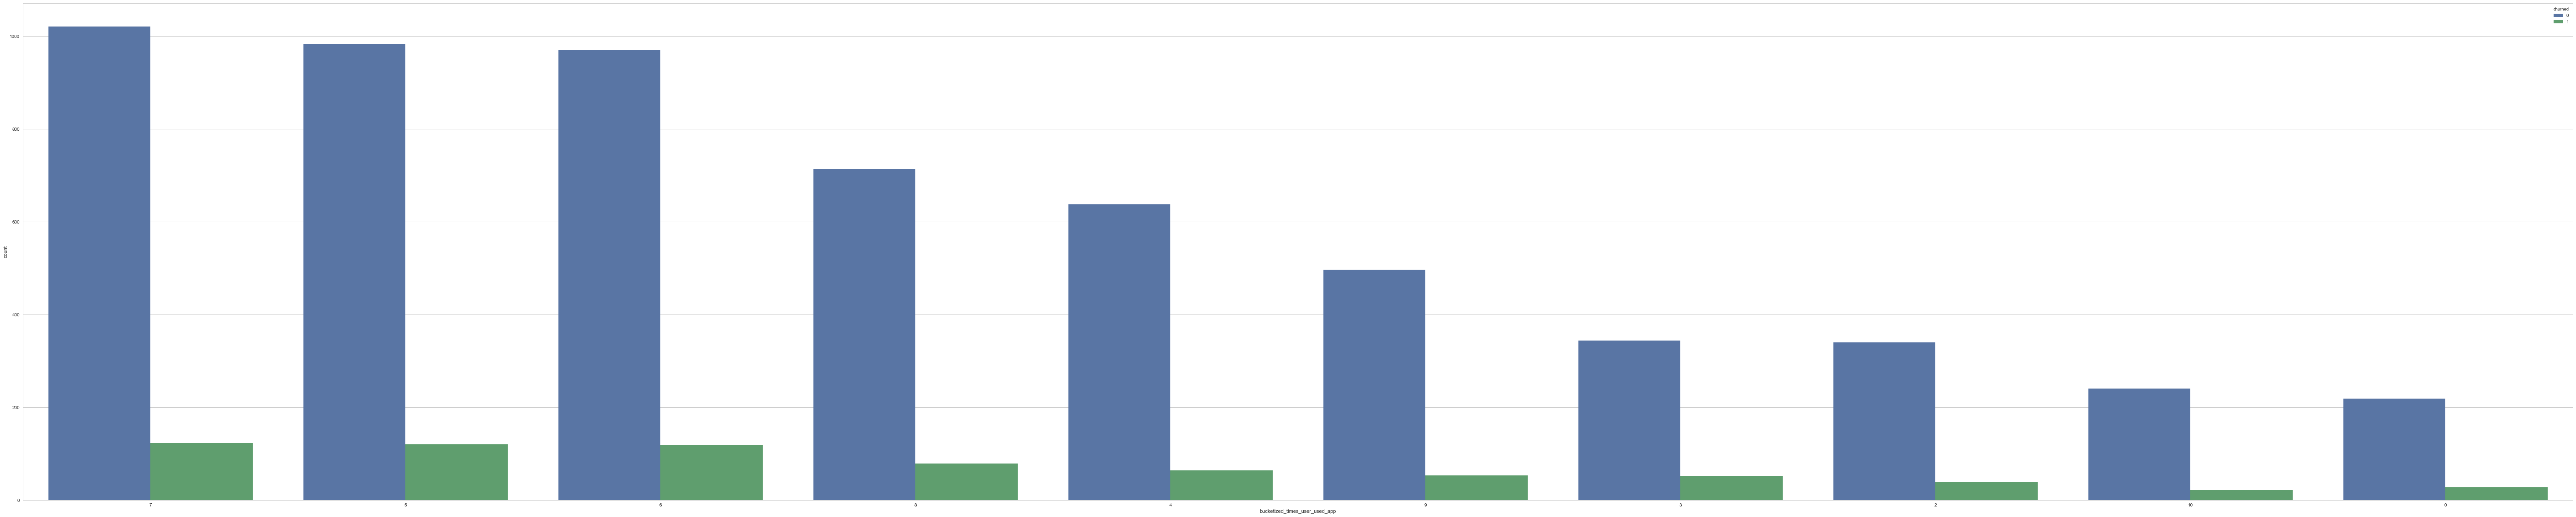

In [556]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_times_user_used_app', 'churned')

In [557]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'times_user_used_app', num_bins=10)

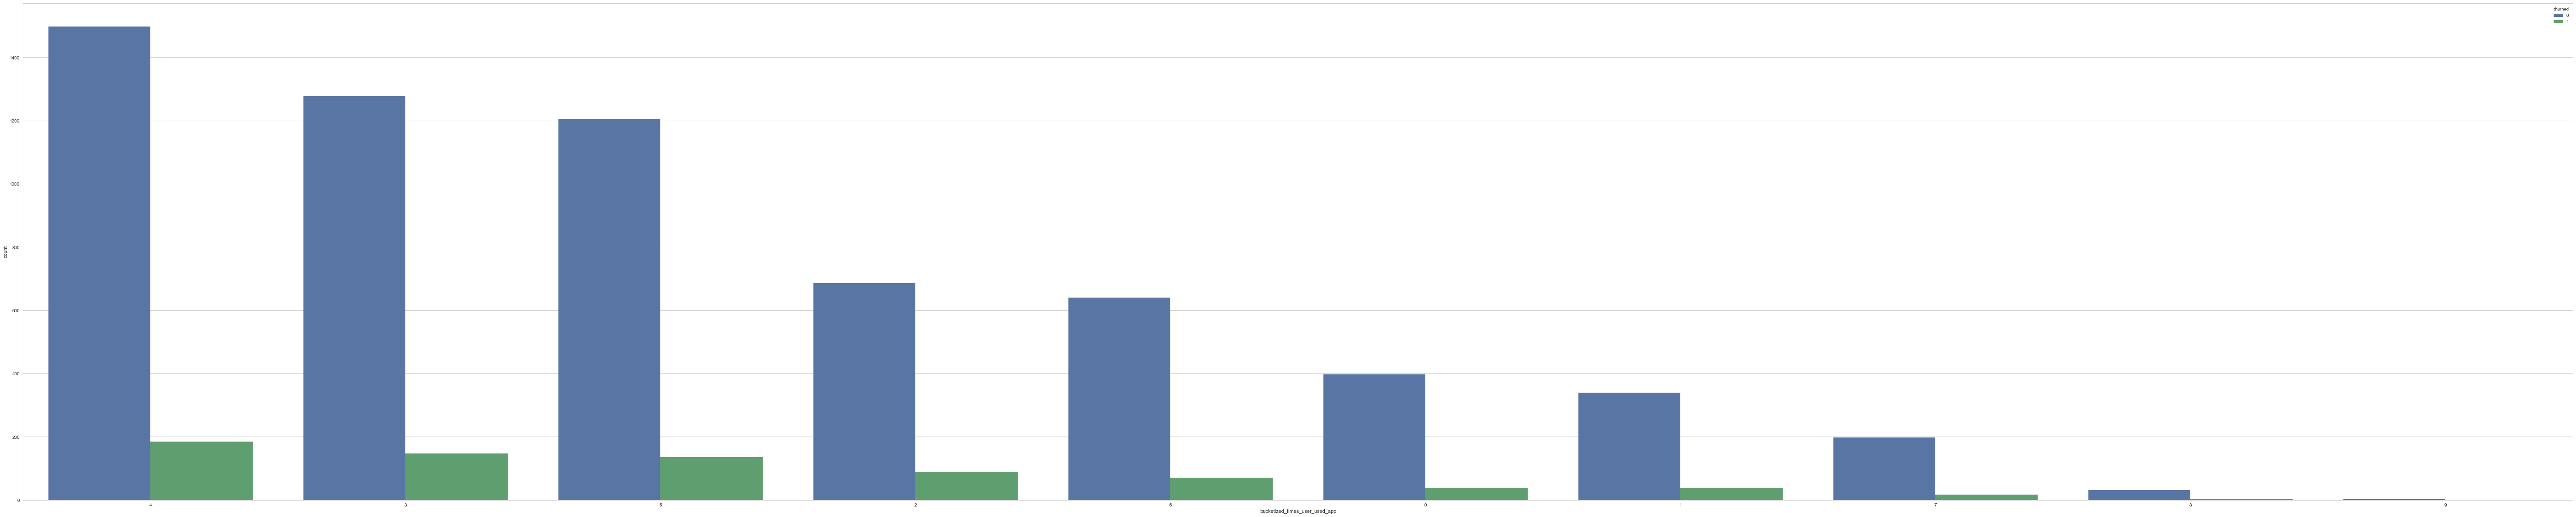

In [558]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_times_user_used_app', 'churned')

In [559]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'times_user_used_app', num_bins=5)

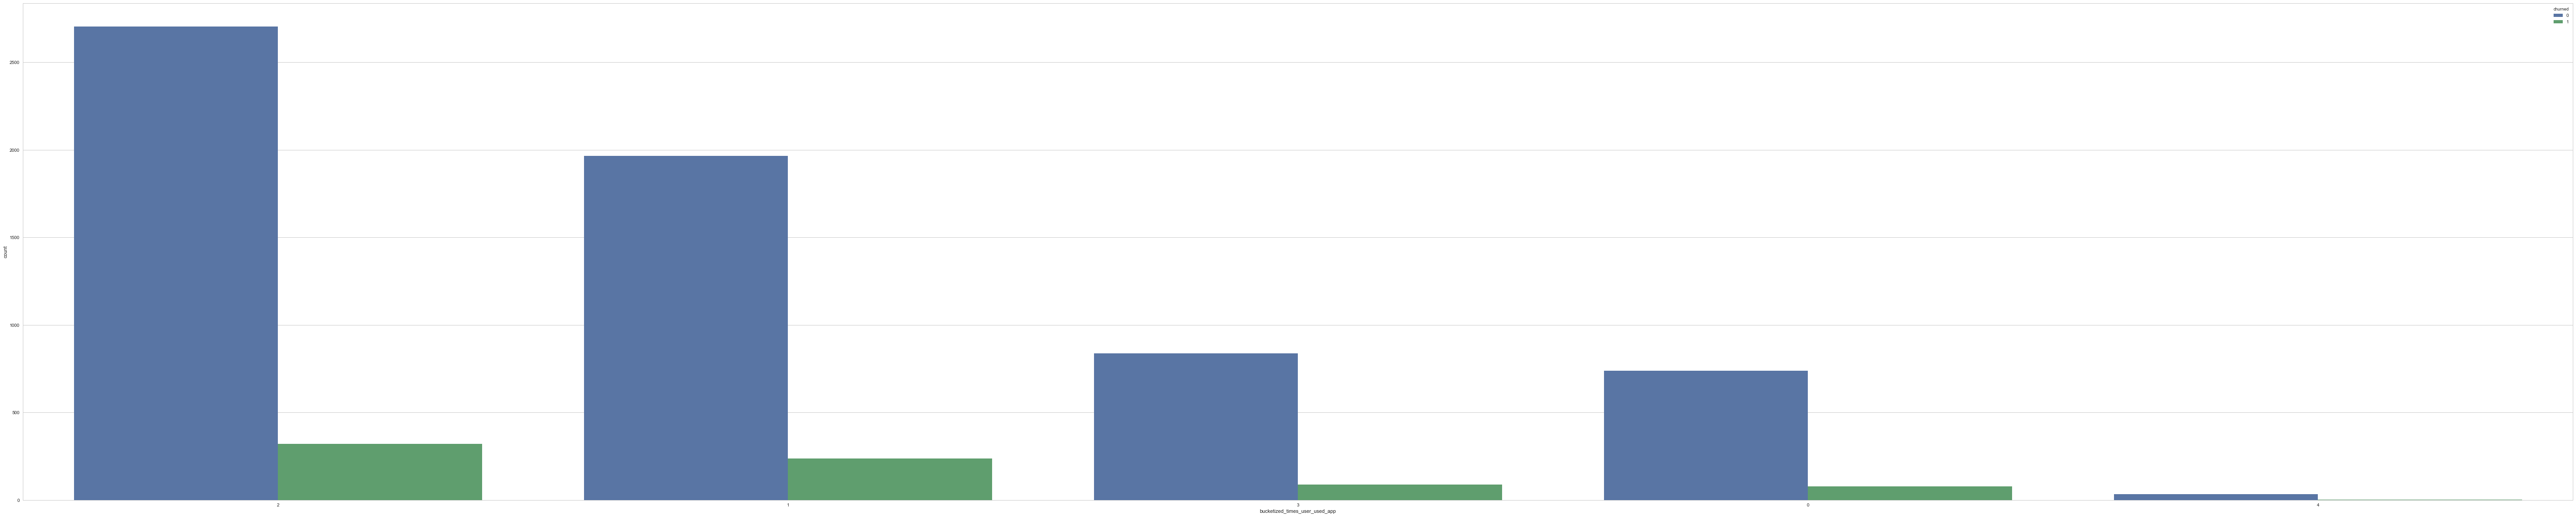

In [560]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_times_user_used_app', 'churned')

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


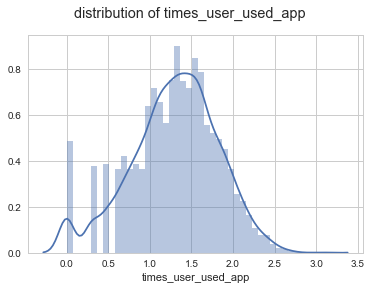

In [561]:
plot_Histogram(train_df_copy,'times_user_used_app')


In [562]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'unique_features', num_bins=15)

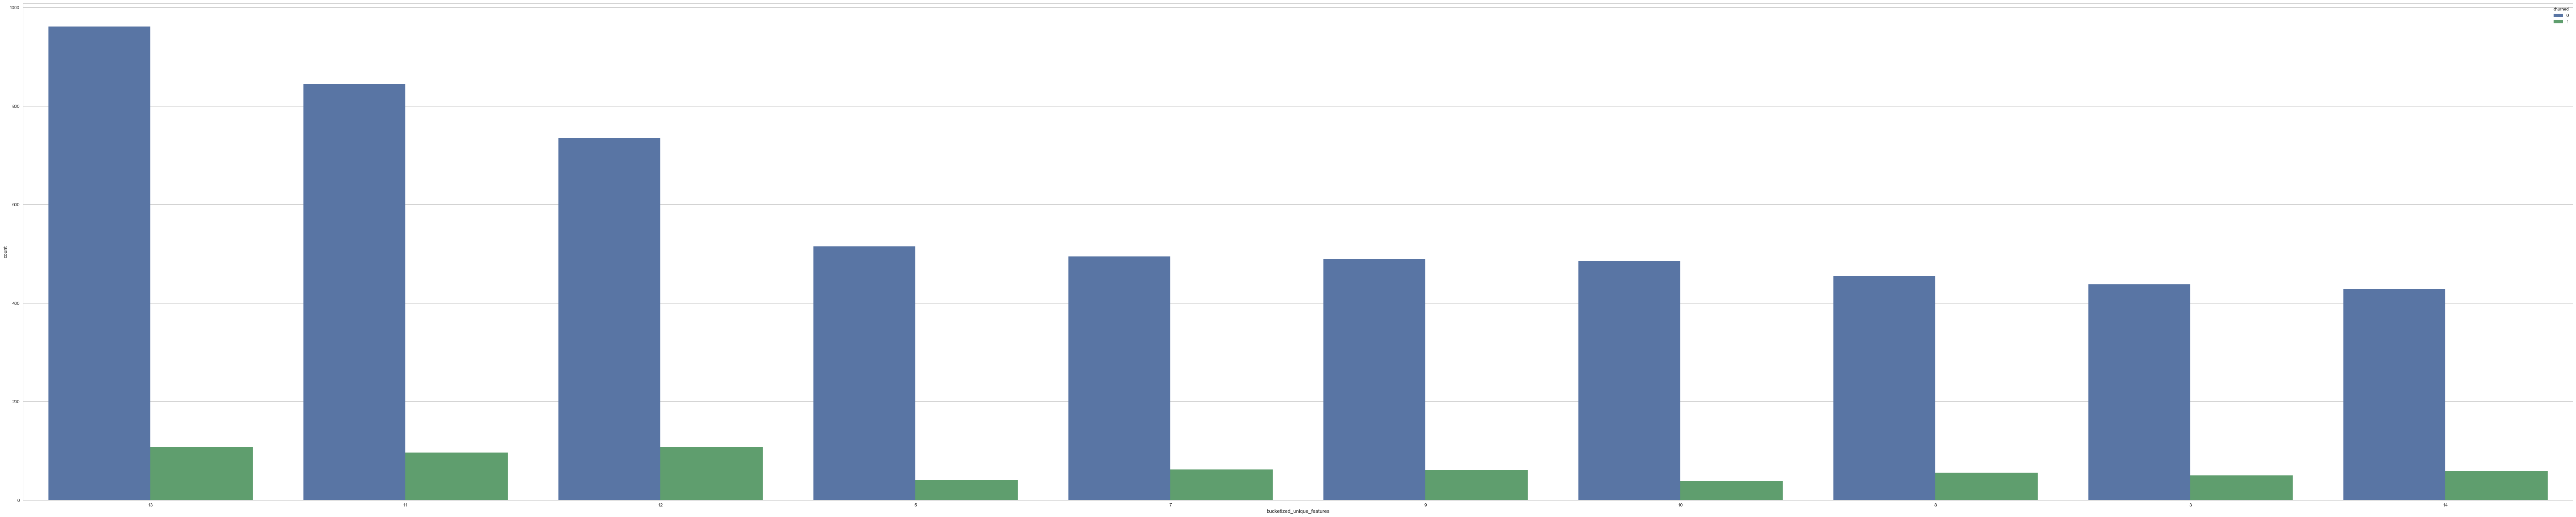

In [563]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_unique_features', 'churned')

In [564]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'unique_features', num_bins=10)

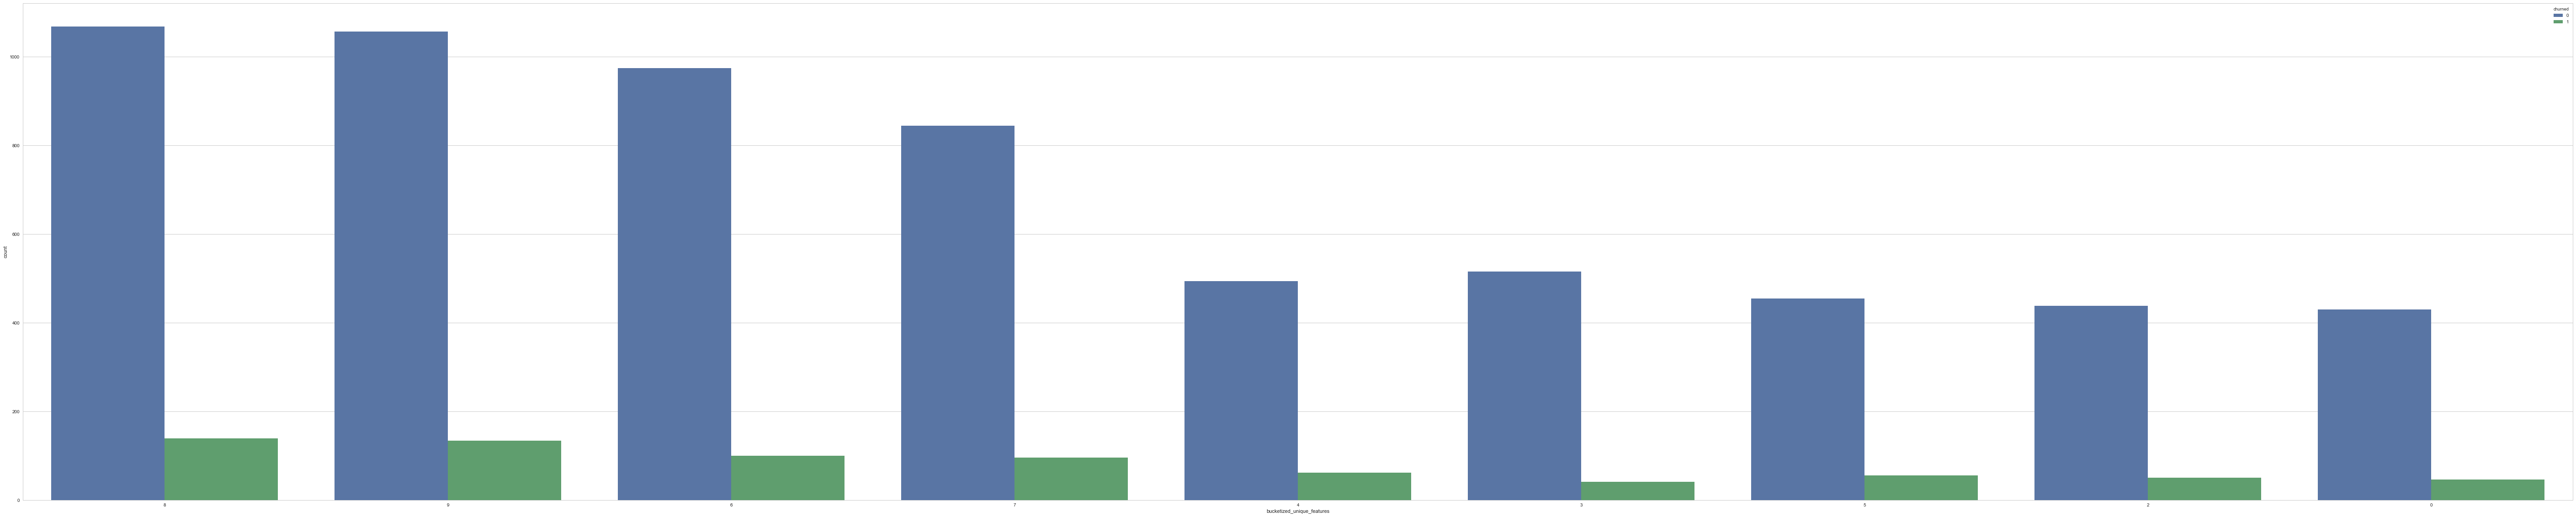

In [565]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_unique_features', 'churned')

In [566]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'unique_features', num_bins=5)

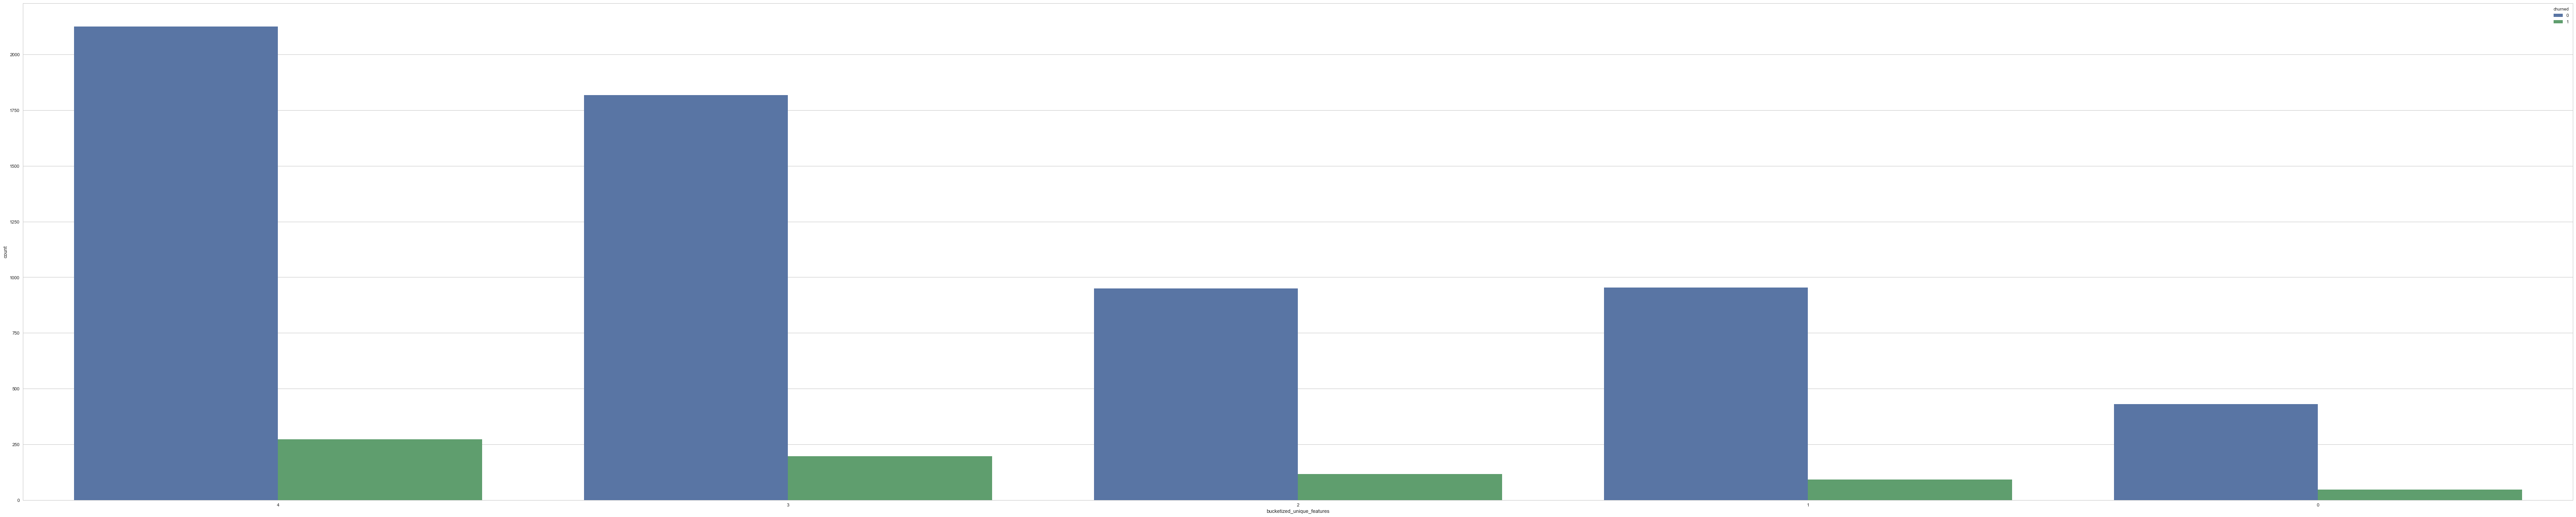

In [567]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_unique_features', 'churned')

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


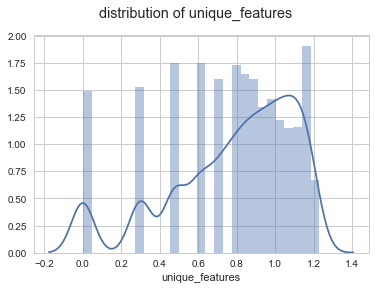

In [568]:
plot_Histogram(train_df_copy,'unique_features')

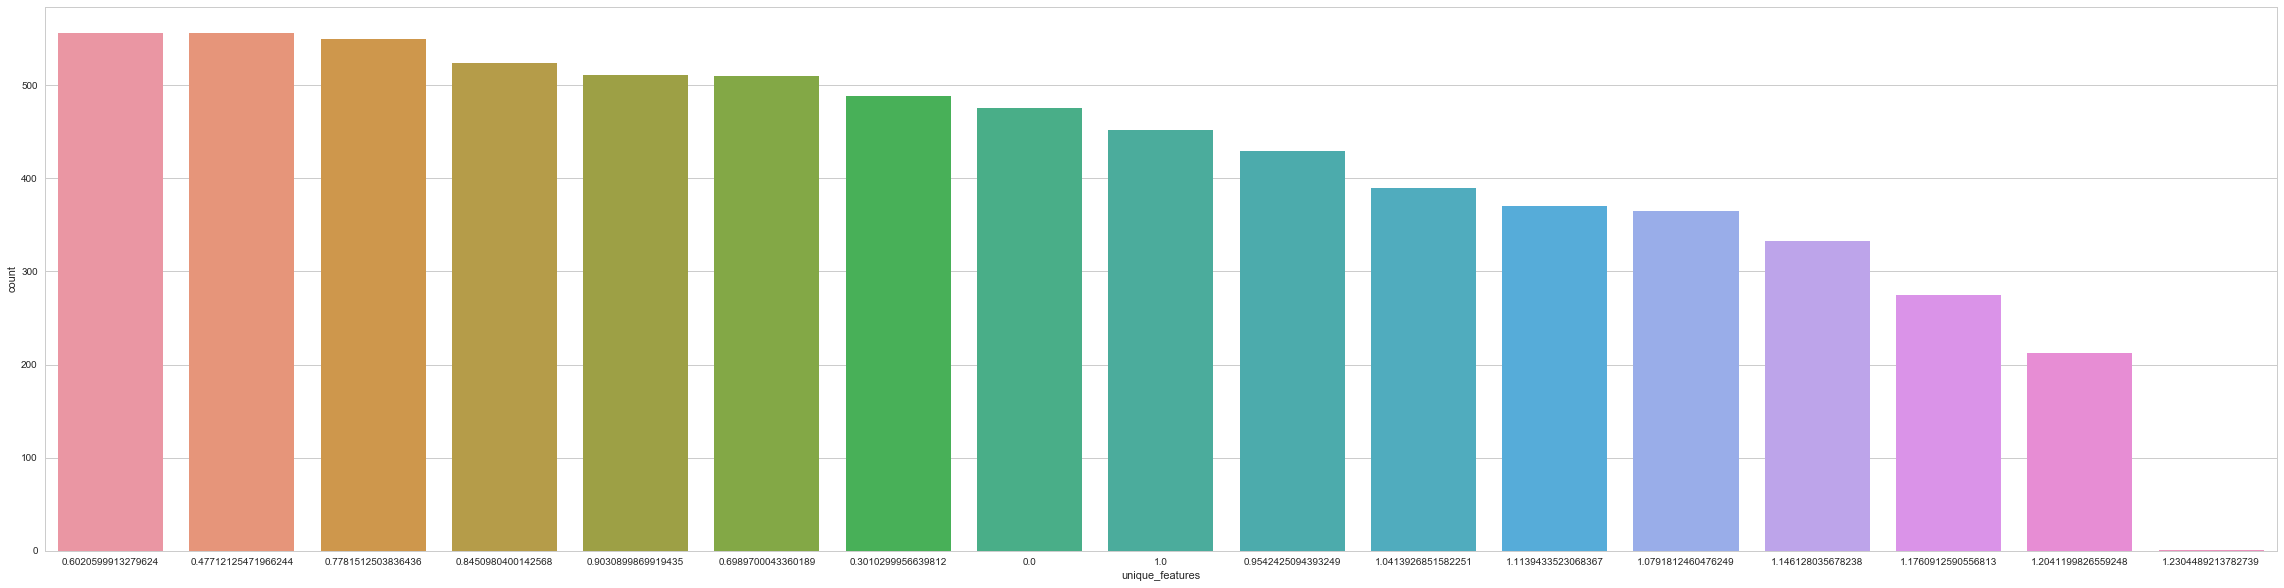

In [569]:
count_Plot_Single_Column(train_df_copy,'unique_features',100)

In [570]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'time_difference_installation_first_time_feature', num_bins=15)

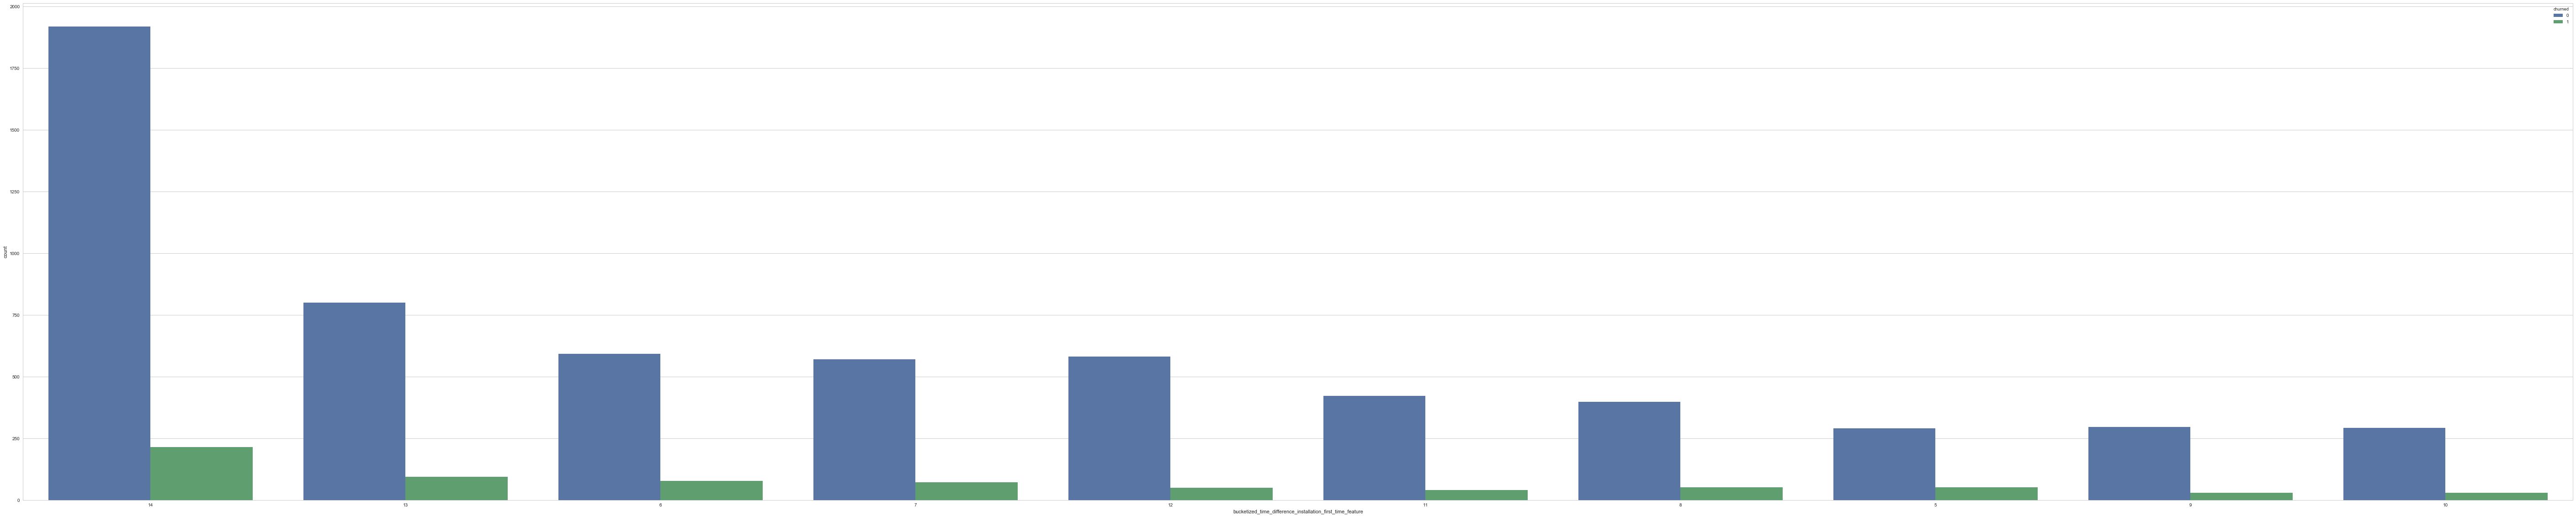

In [571]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_time_difference_installation_first_time_feature', 'churned')

In [572]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'time_difference_installation_first_time_feature', num_bins=10)

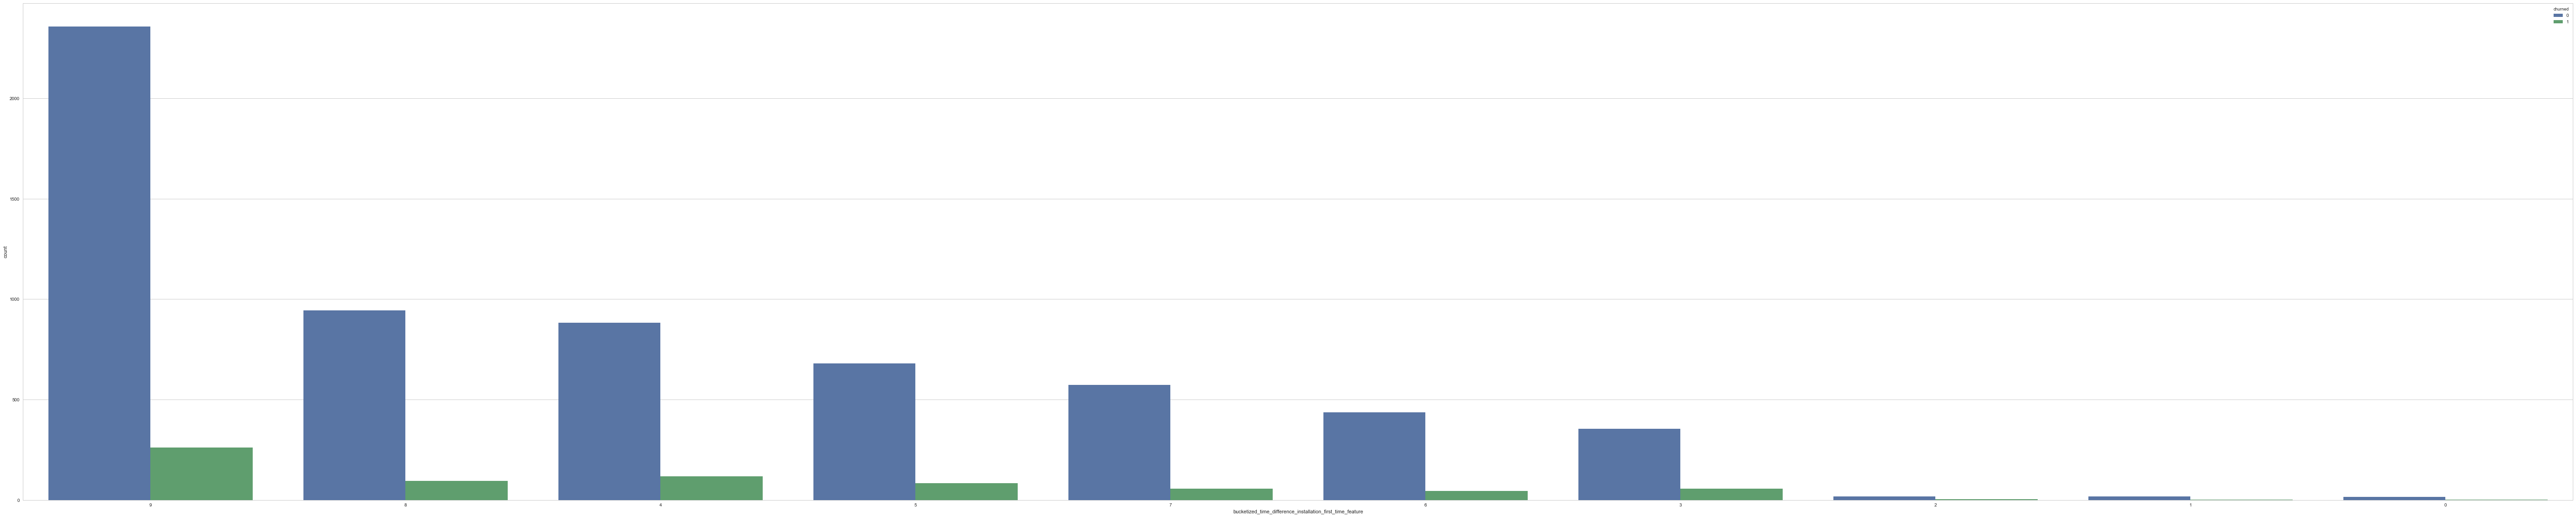

In [573]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_time_difference_installation_first_time_feature', 'churned')

In [574]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'time_difference_installation_first_time_feature', num_bins=5)

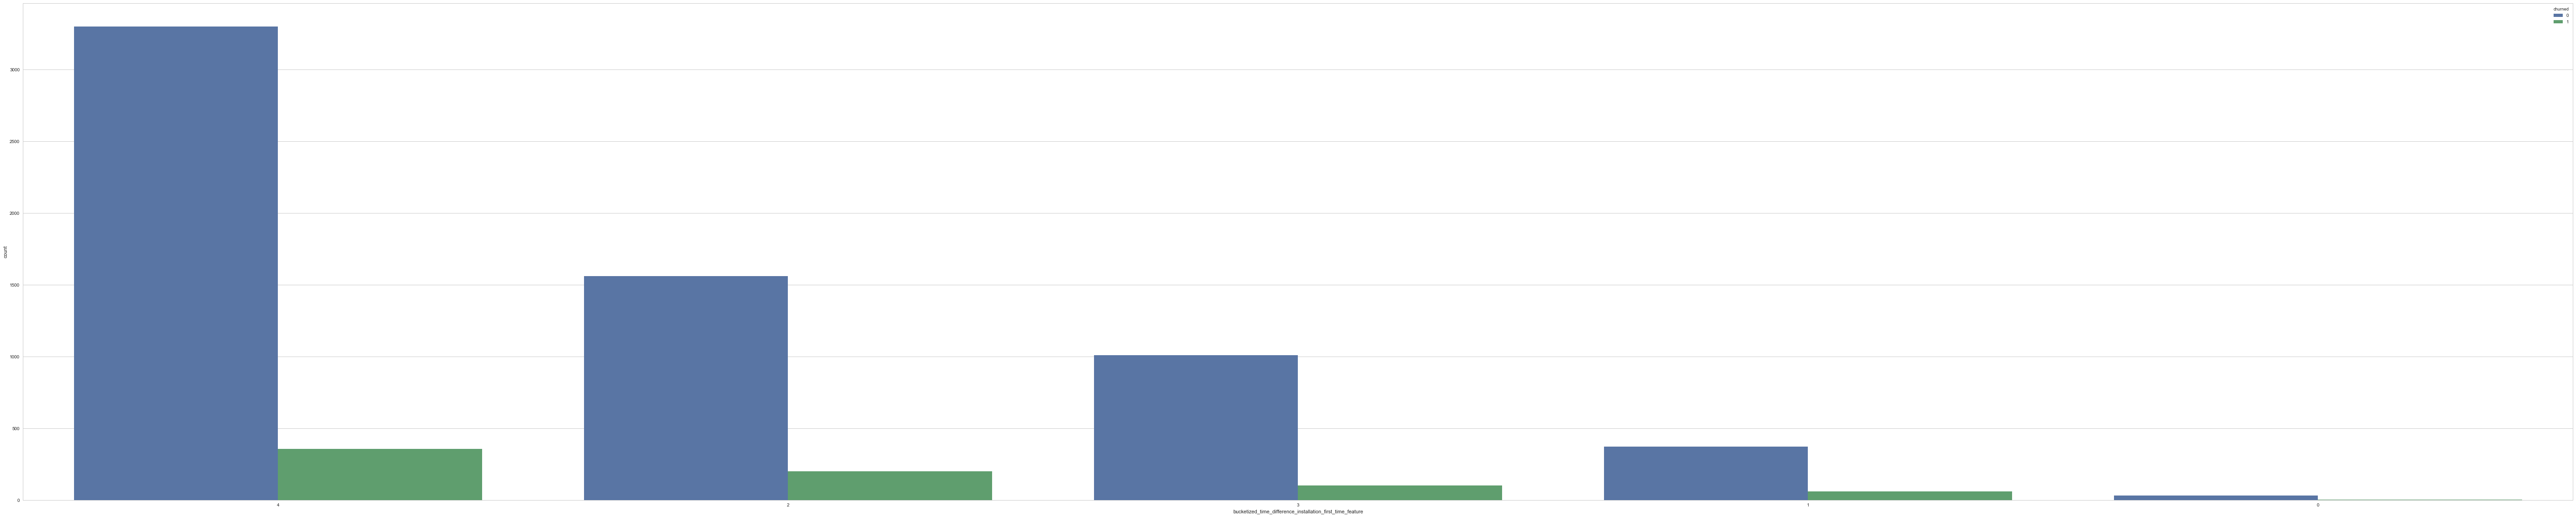

In [575]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_time_difference_installation_first_time_feature', 'churned')

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


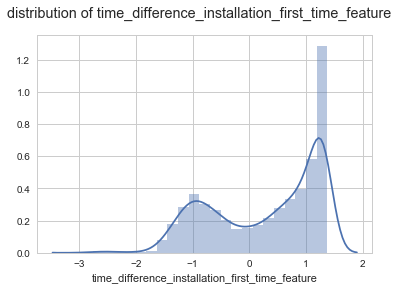

In [576]:
plot_Histogram(train_df_copy,'time_difference_installation_first_time_feature')

In [577]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'time_difference_subscripiton_first_time_feature', num_bins=15)

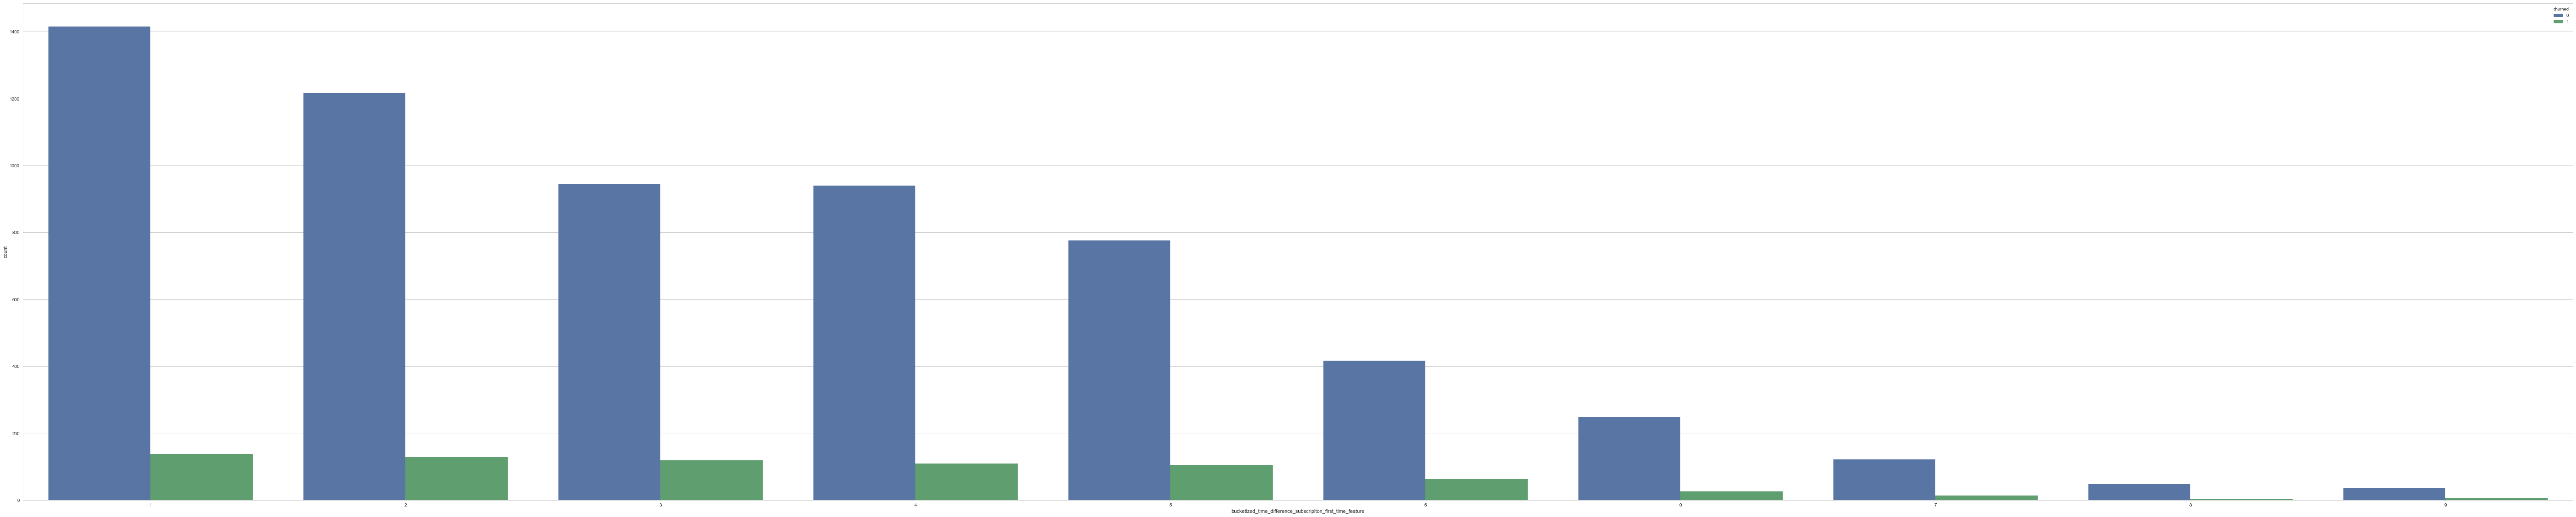

In [578]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_time_difference_subscripiton_first_time_feature', 'churned')

In [579]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'time_difference_subscripiton_first_time_feature', num_bins=10)

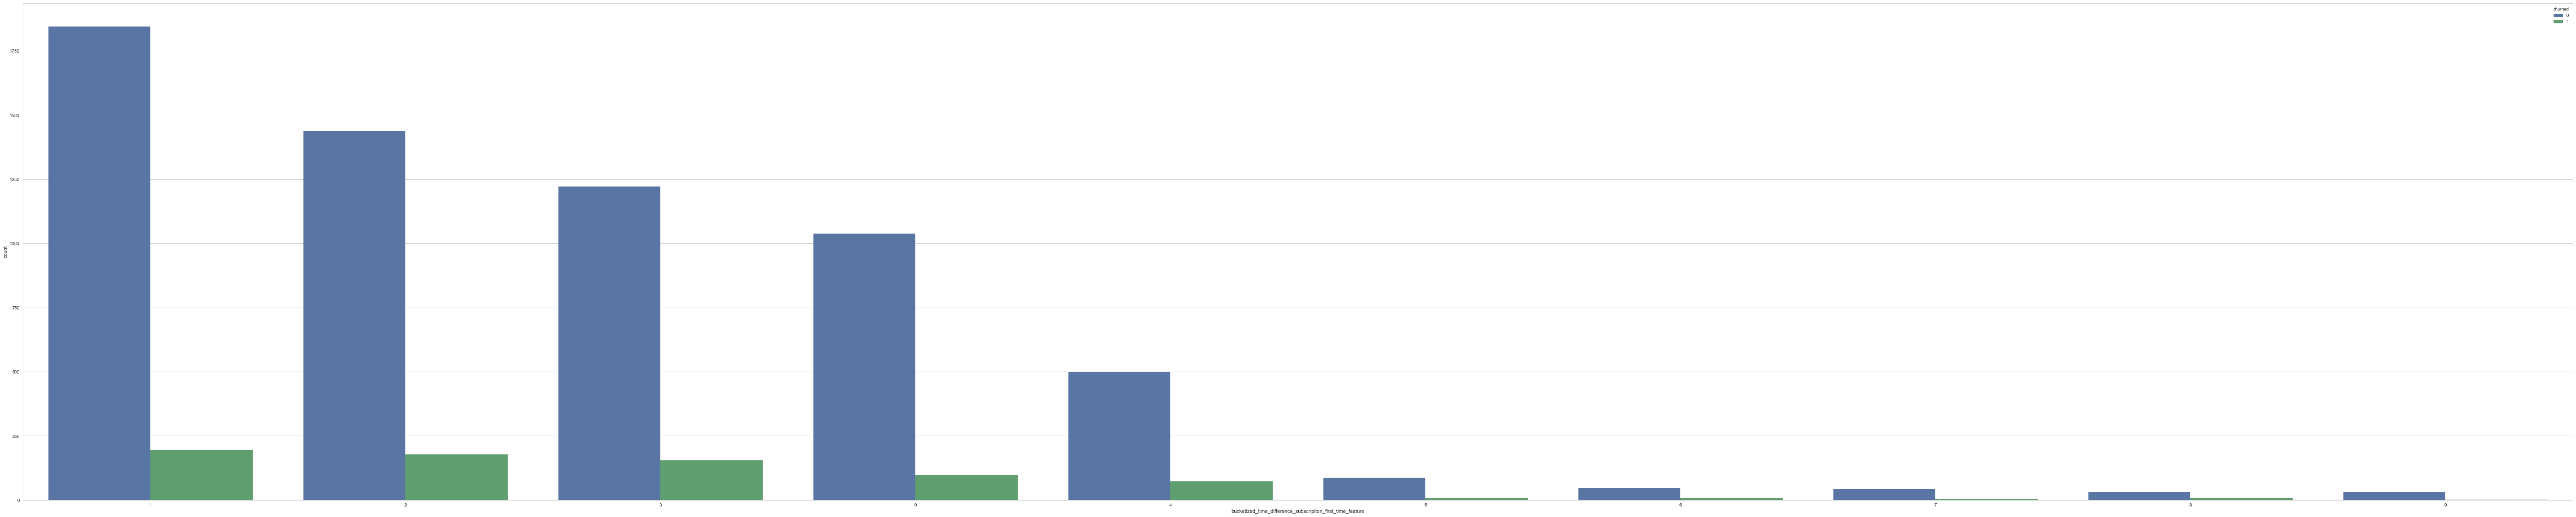

In [580]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_time_difference_subscripiton_first_time_feature', 'churned')

In [581]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'time_difference_subscripiton_first_time_feature', num_bins=5)

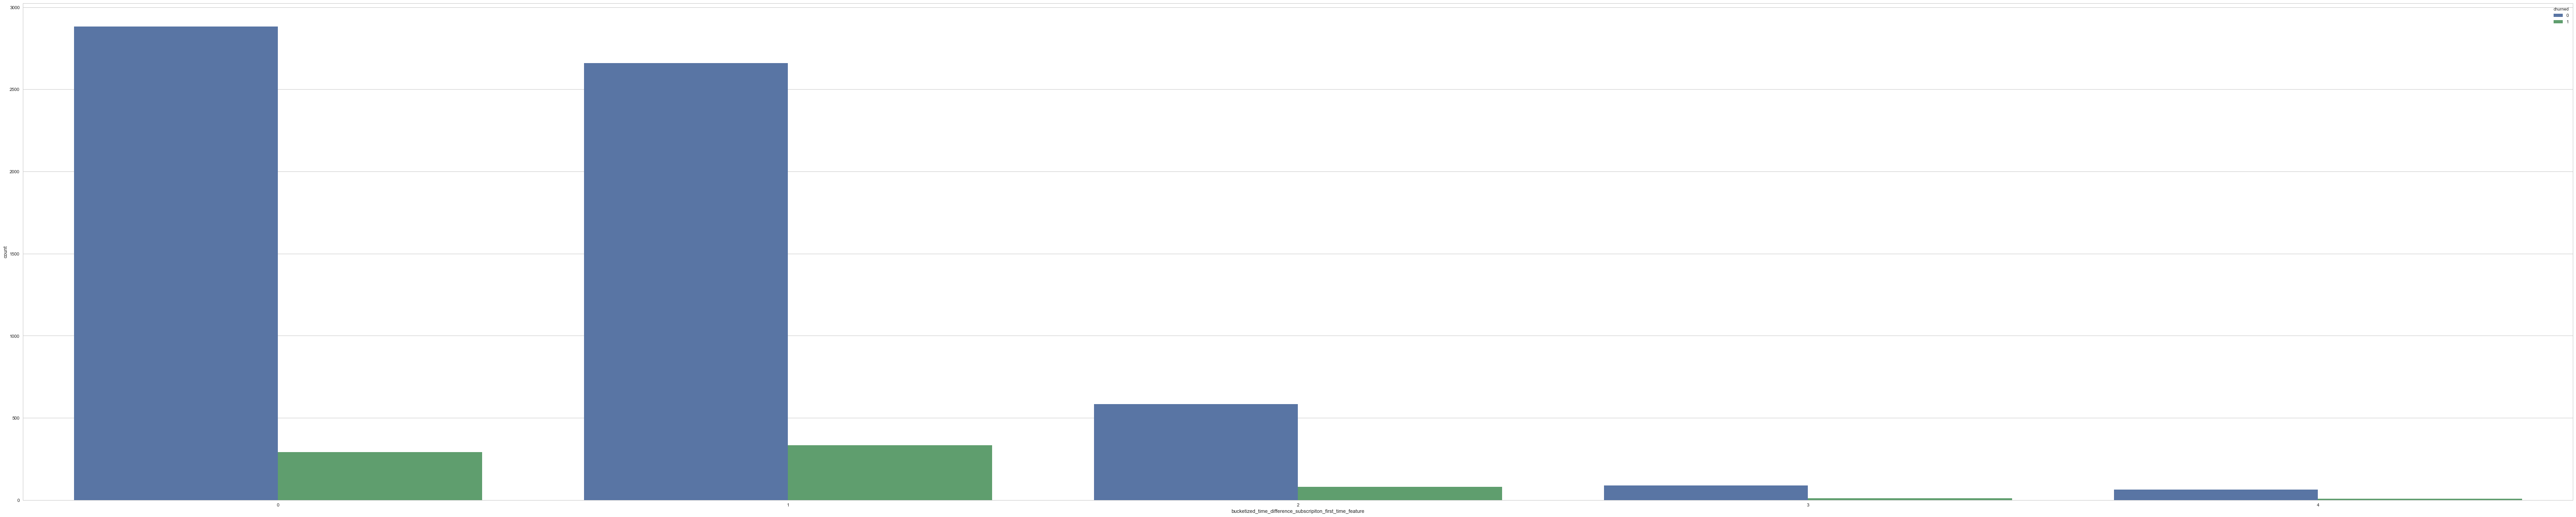

In [582]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_time_difference_subscripiton_first_time_feature', 'churned')

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


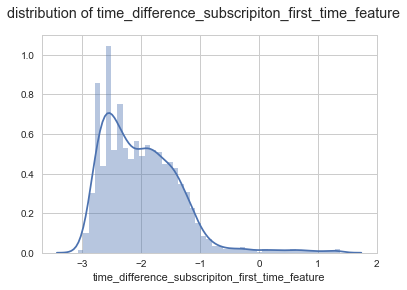

In [583]:
plot_Histogram(train_df_copy,'time_difference_subscripiton_first_time_feature')

In [584]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'average_time_on_feature', num_bins=15)

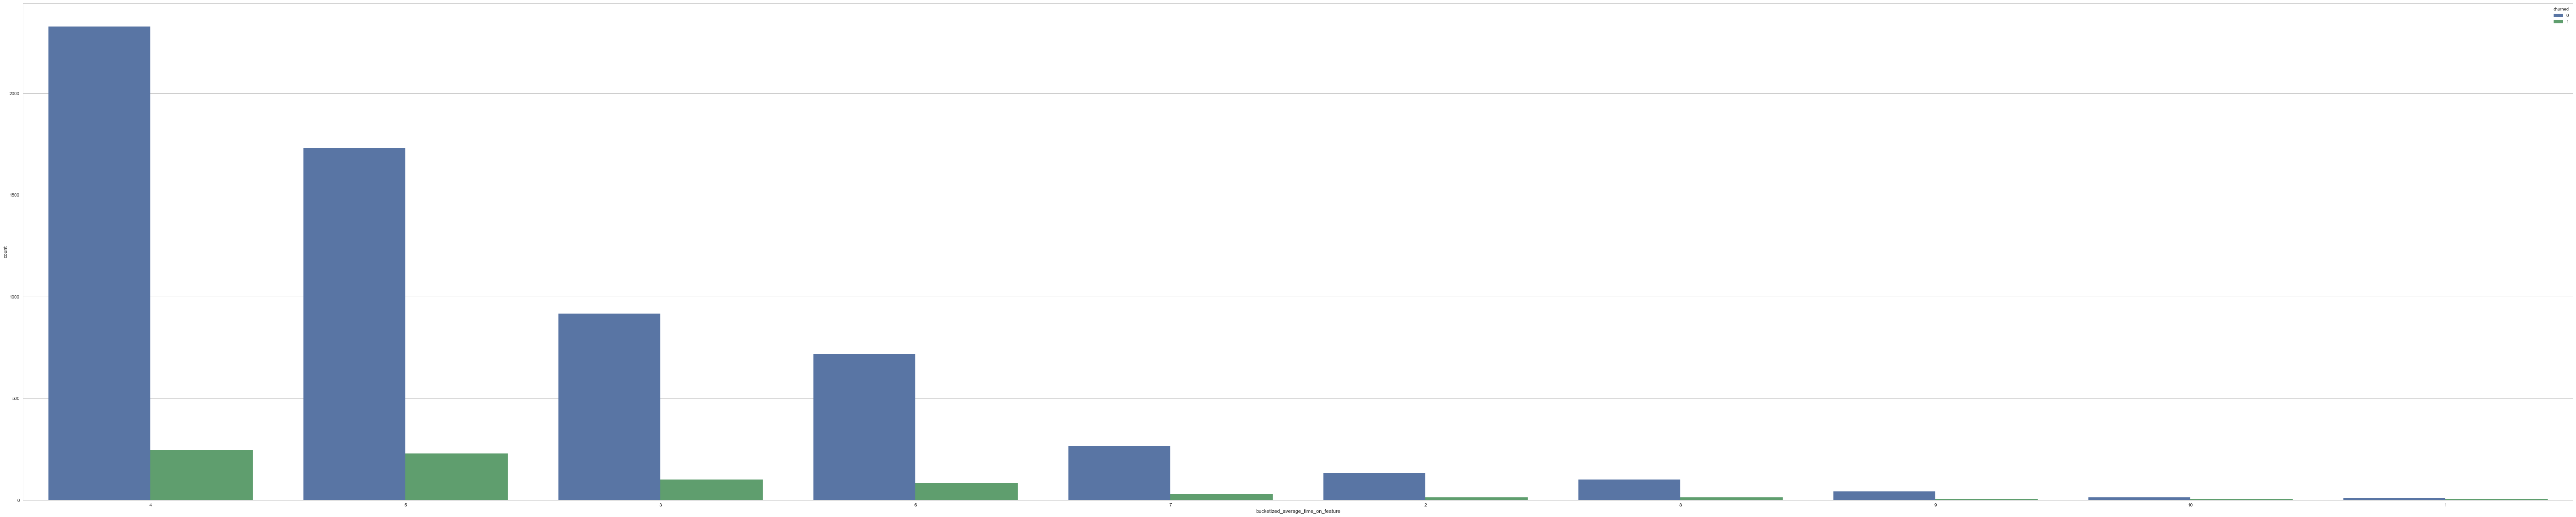

In [585]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_average_time_on_feature', 'churned')

In [586]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'average_time_on_feature', num_bins=10)

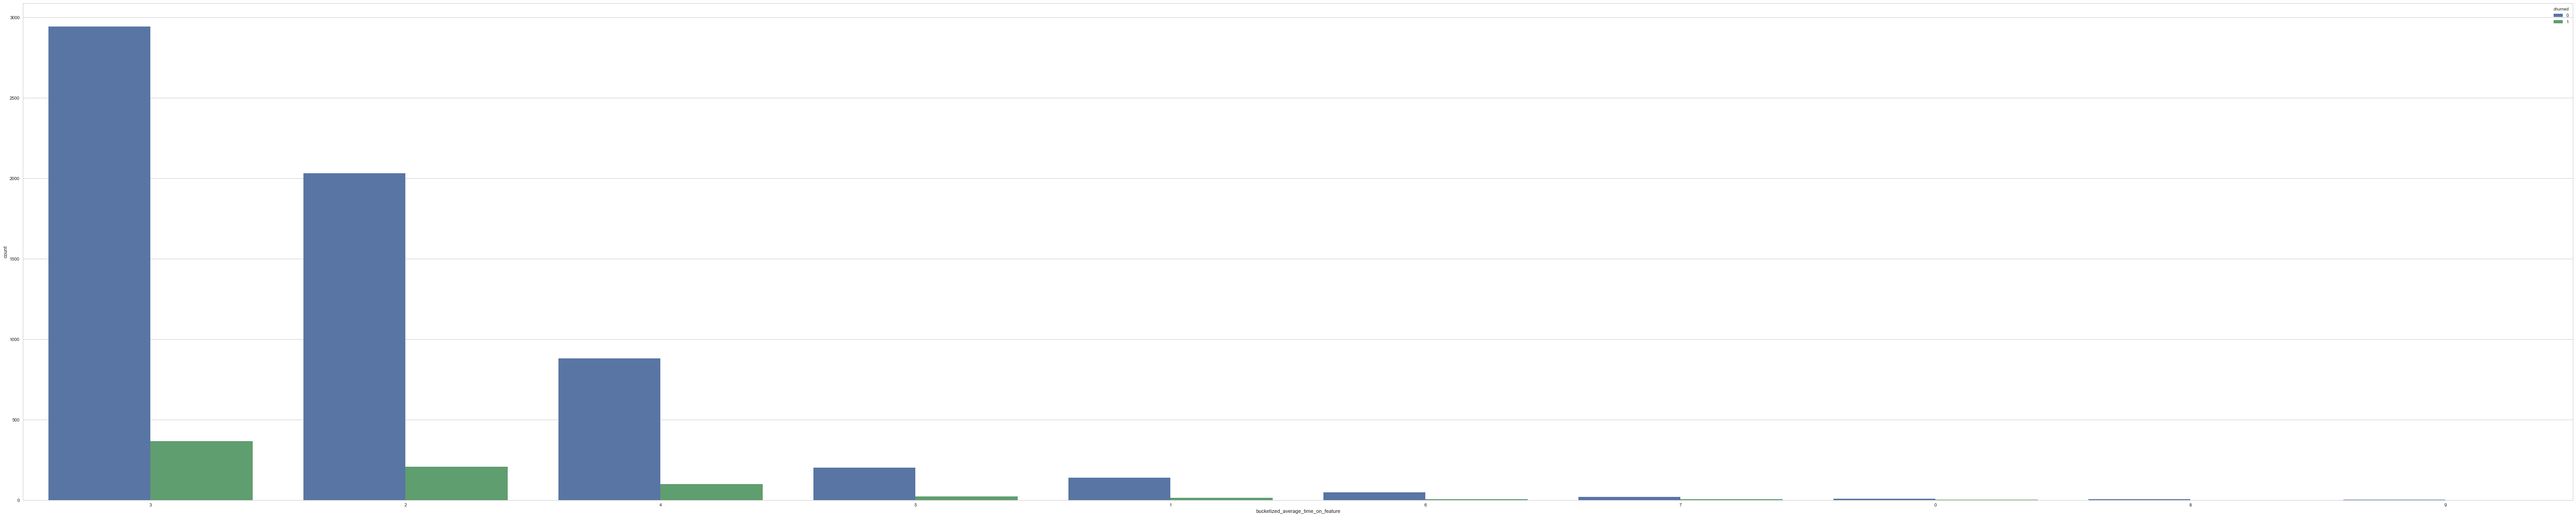

In [587]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_average_time_on_feature', 'churned')

In [588]:
train_df_copy = bucket_Numeric_Variables(train_df_copy,'average_time_on_feature', num_bins=5)

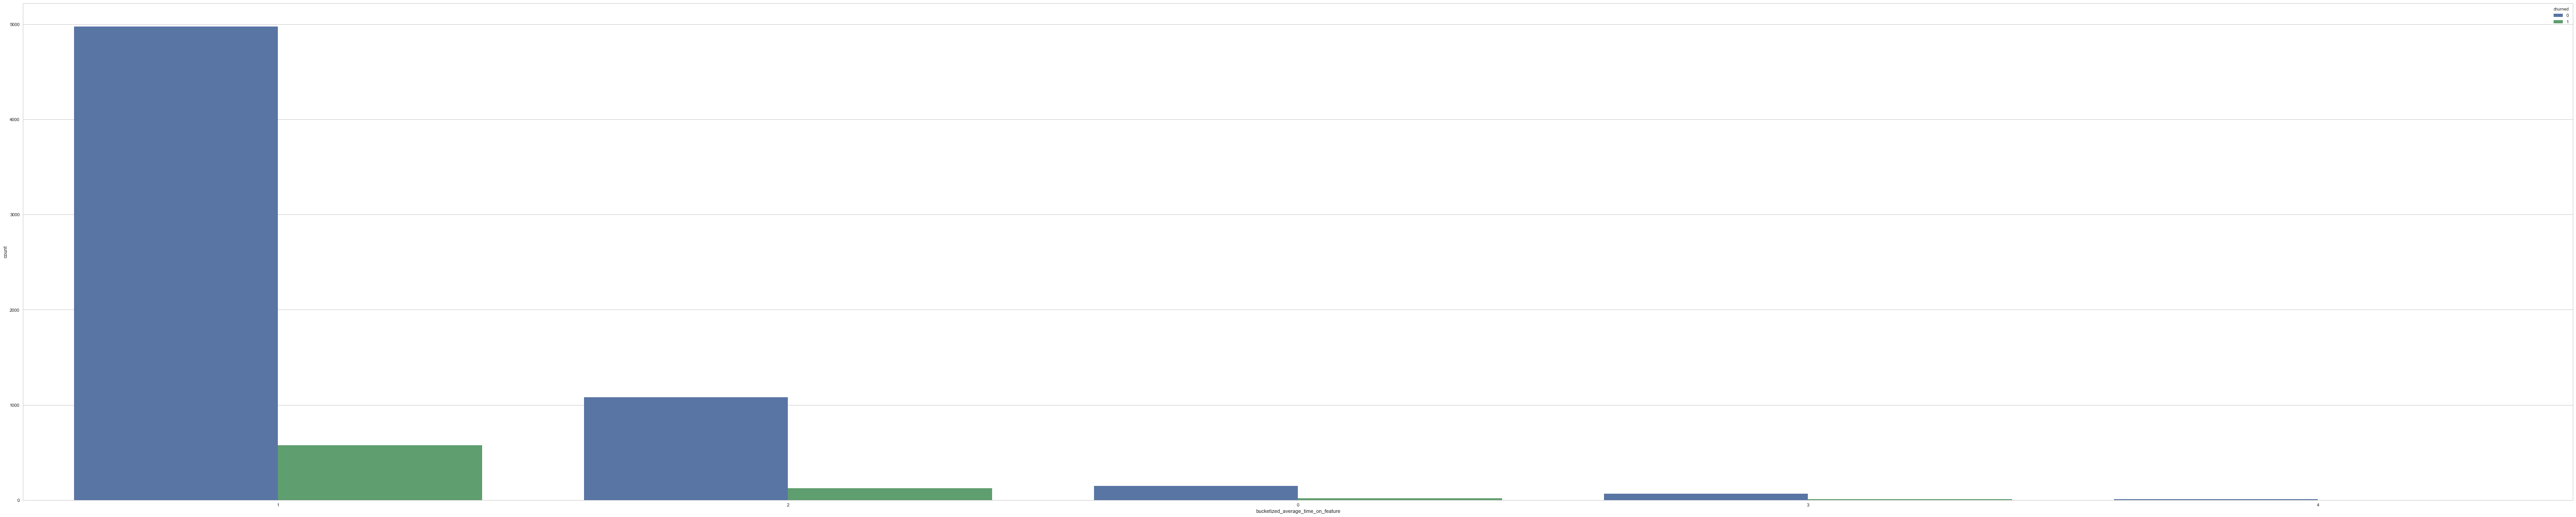

In [589]:
count_Plot_Multiple_Columns(train_df_copy,'bucketized_average_time_on_feature', 'churned')

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


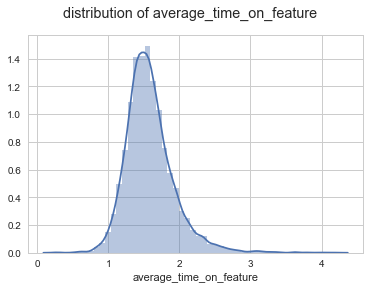

In [590]:
plot_Histogram(train_df_copy,'average_time_on_feature')

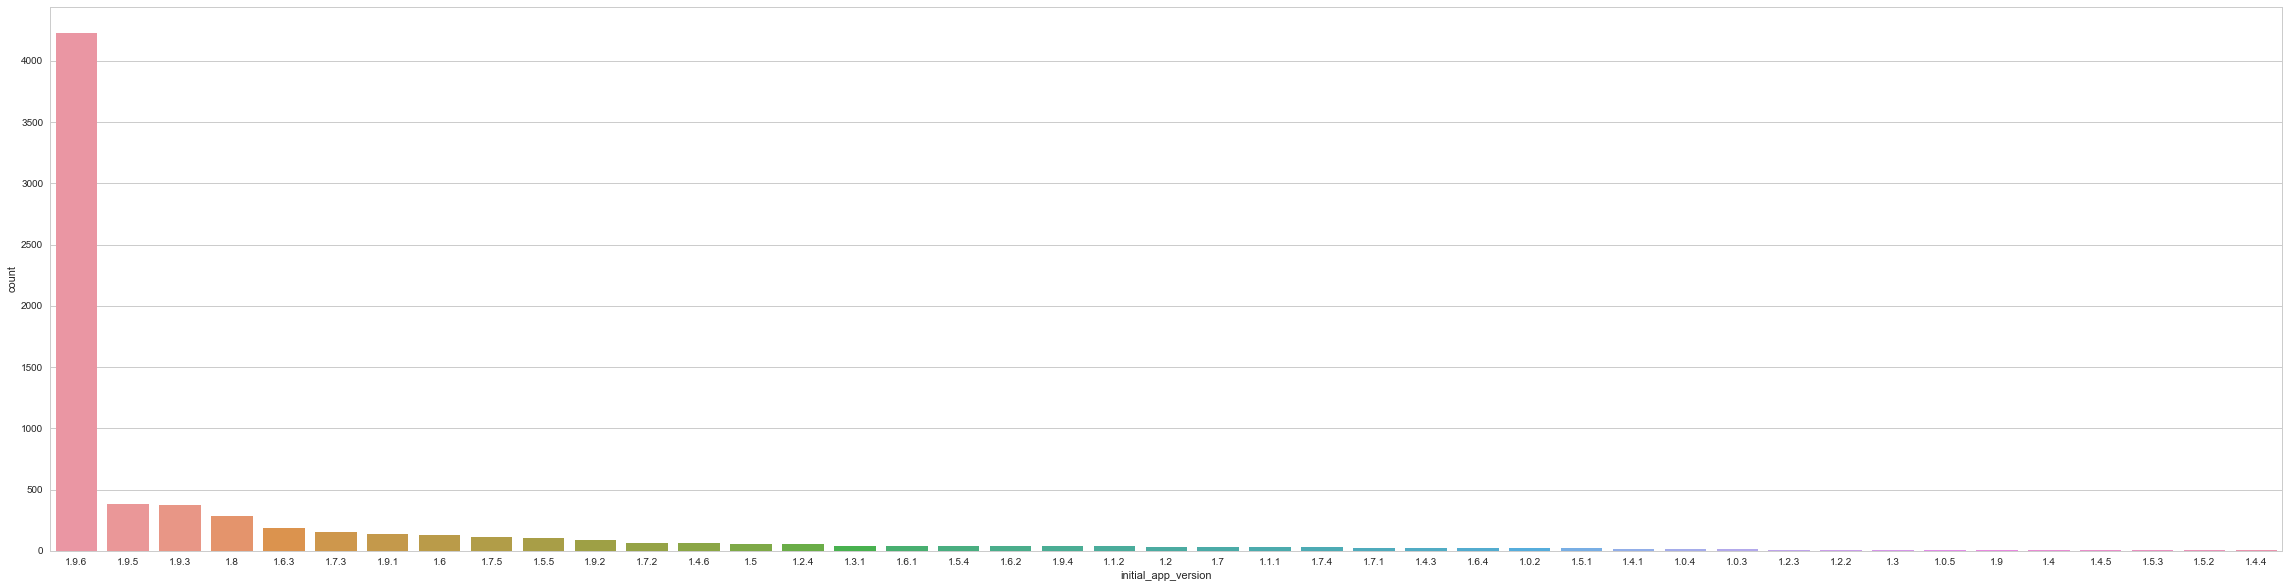

In [591]:
count_Plot_Single_Column(train_df_copy,'initial_app_version',100) 

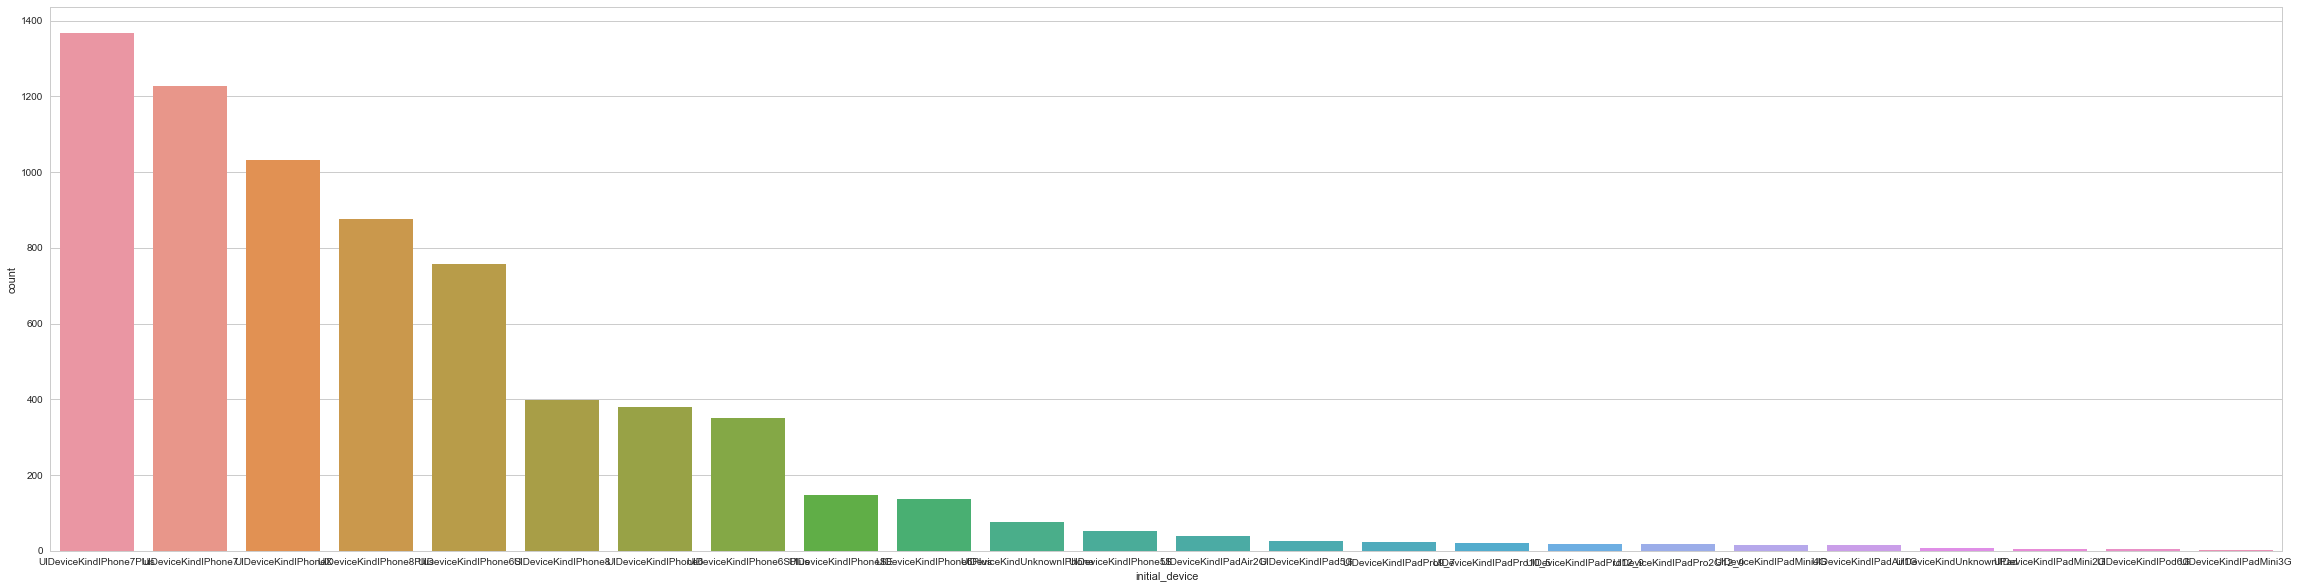

In [592]:
count_Plot_Single_Column(train_df_copy,'initial_device',100) 

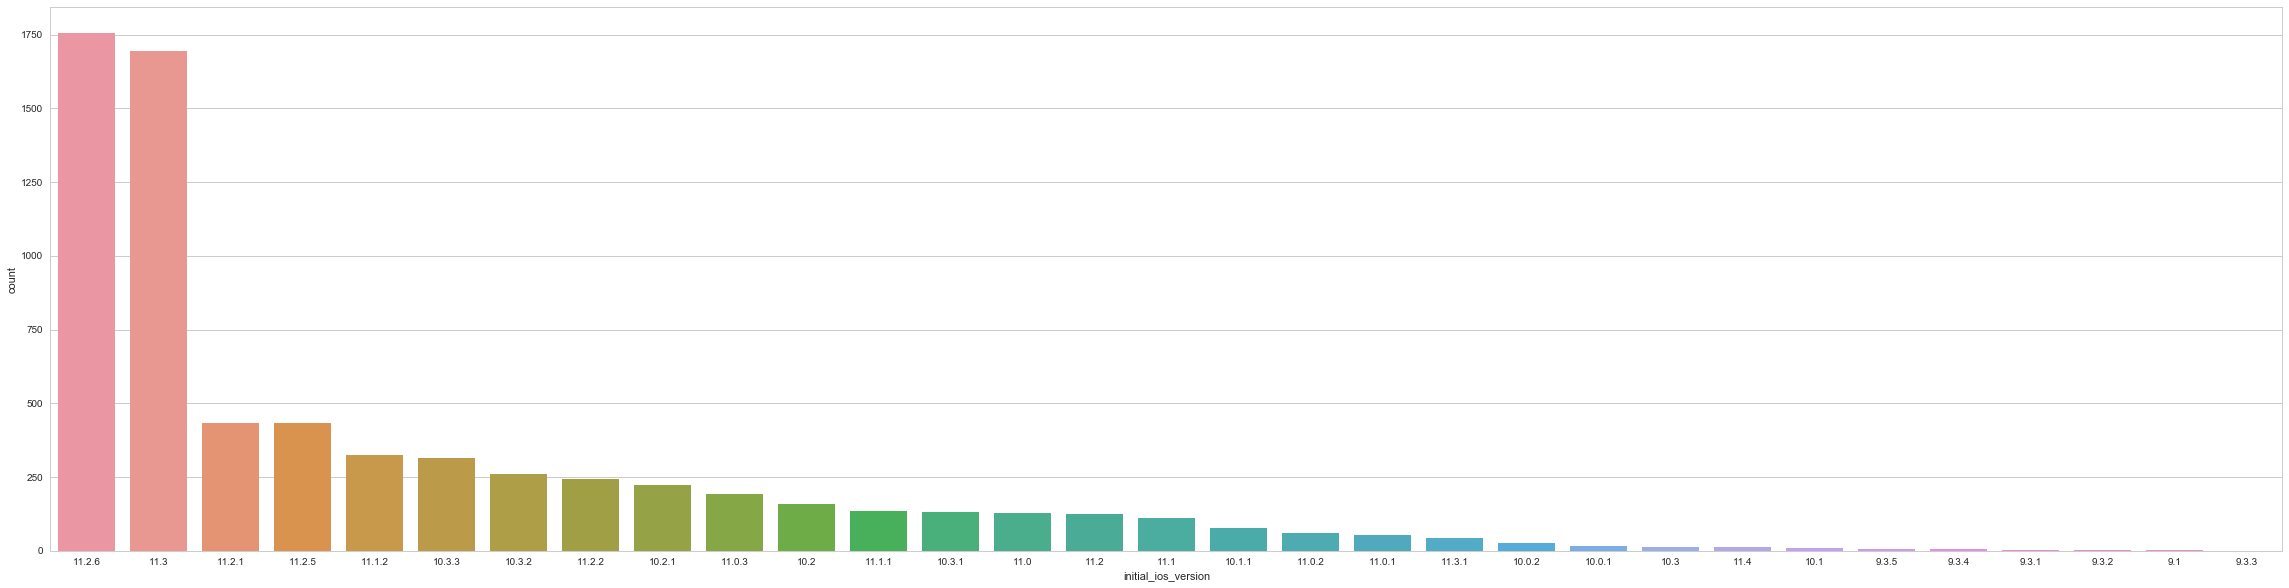

In [593]:
count_Plot_Single_Column(train_df_copy,'initial_ios_version',100) 

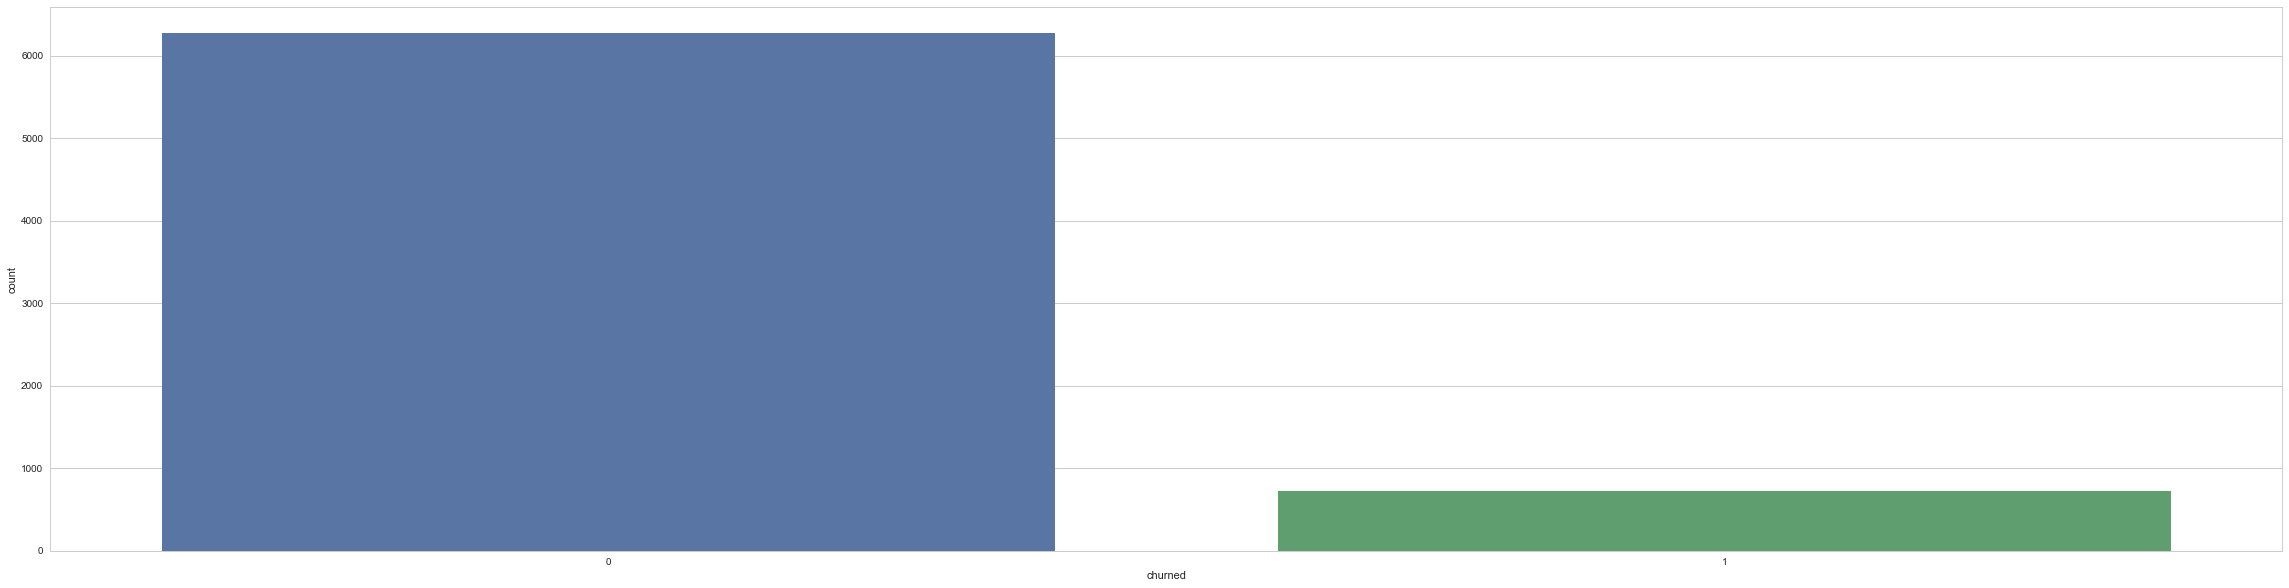

In [594]:
count_Plot_Single_Column(train_df_copy,'churned',100)

from the plot above I can see that the data is imbalanced and I will need to balance the data later

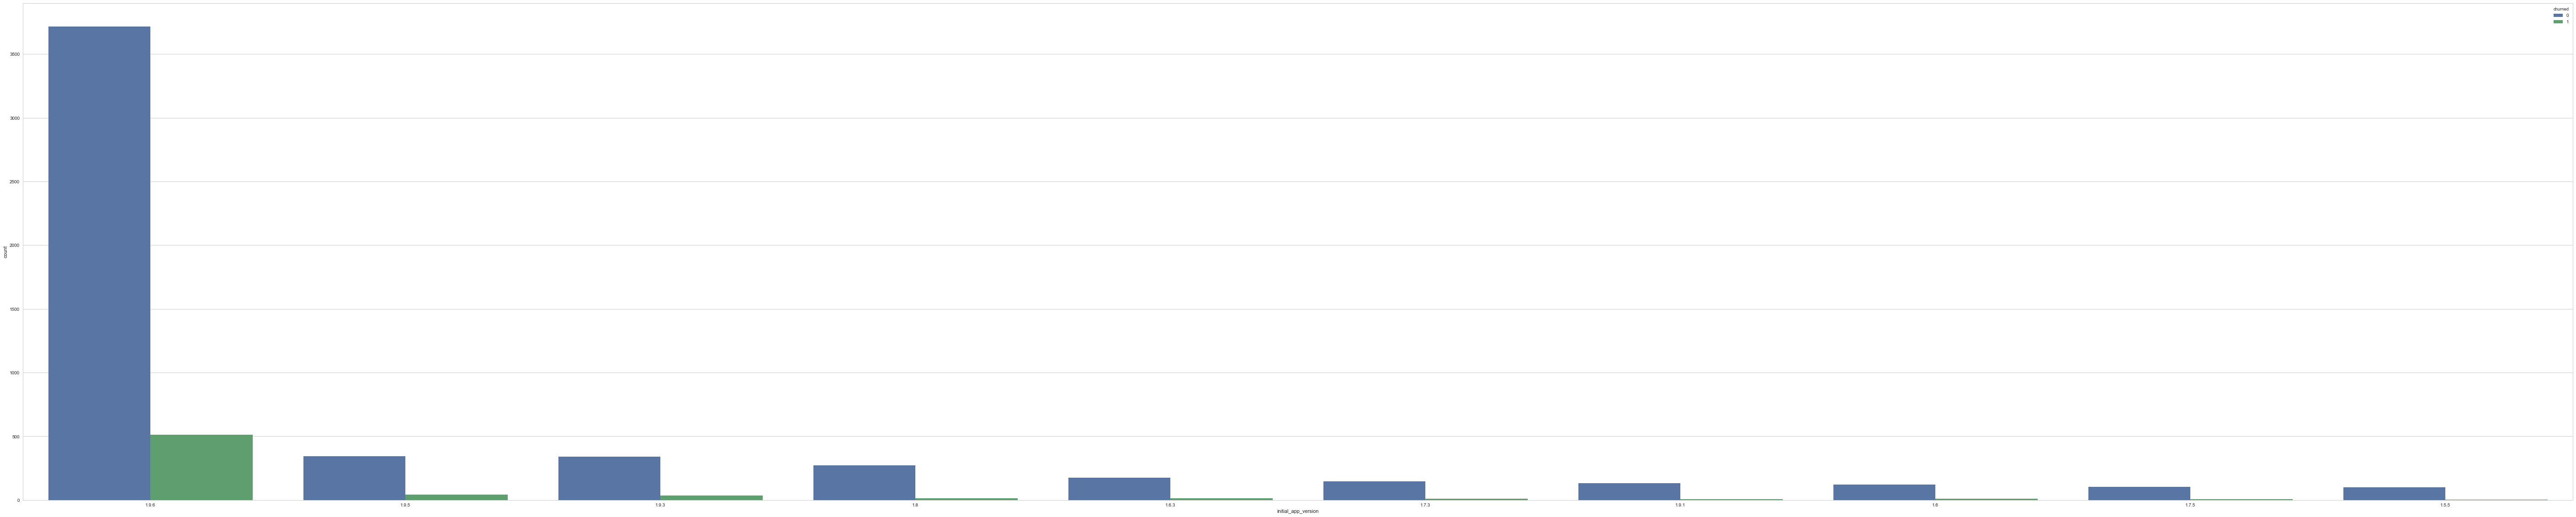

In [595]:
count_Plot_Multiple_Columns(train_df_copy,'initial_app_version', 'churned')

In [596]:
# final number of bins after exploration
train_df_copy = bucket_Numeric_Variables(train_df_copy,'max_time_between_usage', num_bins=15)
train_df_copy = bucket_Numeric_Variables(train_df_copy,'avg_time_between_usage', num_bins=15)
train_df_copy = bucket_Numeric_Variables(train_df_copy,'times_user_used_app', num_bins=15)
train_df_copy = bucket_Numeric_Variables(train_df_copy,'unique_features', num_bins=15)
train_df_copy = bucket_Numeric_Variables(train_df_copy,'time_difference_installation_first_time_feature', num_bins=15)
train_df_copy = bucket_Numeric_Variables(train_df_copy,'time_difference_subscripiton_first_time_feature', num_bins=15)
train_df_copy = bucket_Numeric_Variables(train_df_copy,'average_time_on_feature', num_bins=15)

## Chi-Square tests

In [597]:
ch1 =  chi_Square_Test(interecation_Between_Two_Categorical_Variables(train_df_copy,'churned','initial_app_version'))[1]
ch1

0.00042629334512013078

In [598]:
ch2 =  chi_Square_Test(interecation_Between_Two_Categorical_Variables(train_df_copy,'churned','initial_device'))[1]
ch2

0.091246971158345597

In [599]:
ch3 =  chi_Square_Test(interecation_Between_Two_Categorical_Variables(train_df_copy,'churned','initial_ios_version'))[1]
ch3

0.00061562958895249747

In [600]:
ch4 =  chi_Square_Test(interecation_Between_Two_Categorical_Variables(train_df_copy,'churned','country'))[1]
ch4

0.94162568996419094

In [601]:
ch5 =  chi_Square_Test(interecation_Between_Two_Categorical_Variables(train_df_copy,'churned','bucketized_avg_time_between_usage'))[1]
ch5

0.040753737311387726

In [602]:
ch6 =  chi_Square_Test(interecation_Between_Two_Categorical_Variables(train_df_copy,'churned','bucketized_max_time_between_usage'))[1]
ch6

0.44730094857133362

In [603]:
ch7 =  chi_Square_Test(interecation_Between_Two_Categorical_Variables(train_df_copy,'churned','bucketized_times_user_used_app'))[1]
ch7

0.62399649308653848

In [604]:
ch8 =  chi_Square_Test(interecation_Between_Two_Categorical_Variables(train_df_copy,'churned','bucketized_unique_features'))[1]
ch8

0.055825509408768036

In [605]:
ch9 =  chi_Square_Test(interecation_Between_Two_Categorical_Variables(train_df_copy,'churned','bucketized_time_difference_installation_first_time_feature'))[1]
ch9

0.068679669991778741

In [606]:
ch10 =  chi_Square_Test(interecation_Between_Two_Categorical_Variables(train_df_copy,'churned','bucketized_time_difference_subscripiton_first_time_feature'))[1]
ch10

0.15245533106673645

In [607]:
ch11 =  chi_Square_Test(interecation_Between_Two_Categorical_Variables(train_df_copy,'churned','bucketized_average_time_on_feature'))[1]
ch11

0.32463582404343483

In [608]:
# the features that I take to the models are: initial_app_version, initial_ios_version, bucketized_avg_time_between_usage, bucketized_unique_features, bucketized_time_difference_installation_first_time_feature

In [609]:
train_x = train_df_copy[['initial_app_version', 'initial_ios_version', 'bucketized_avg_time_between_usage', 'bucketized_unique_features', 'bucketized_time_difference_installation_first_time_feature']]
train_y = train_df_copy[['churned']]

In [610]:
train_x = pd.get_dummies(train_x)

In [611]:
train_x.shape

(6998, 110)

## Balance The Data By Resampling

In [612]:
X_res, y_res = balance_Data_SMOTE(train_x.values,train_y.values,ratio='auto')

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Prepare Test Data

In [627]:
mode_initial_app_version = test_users_data_with_target['initial_app_version'].mode()[0]
test_users_data_with_target['initial_app_version'] = test_users_data_with_target['initial_app_version'].replace('1.2.1',mode_initial_app_version)
test_users_data_with_target['country'] = test_users_data_with_target['country'].fillna(test_users_data_with_target['country'].mode()[0]) # fill missing value with the mode value



avg_Time_Between_Usage_test = avg_Time_Between_Usage(test_all_data,'id','end_use_date') #  missing 250 values
max_time_between_usage_test = max_Time_Between_Usage(test_all_data,'id','end_use_date') #  missing 250 values
number_Of_Times_The_User_Used_The_App_test = number_Of_Times_The_User_Used_The_App(test_all_data,column_name='id') # same
unique_Fitures_Per_User_test = unique_Fitures_Per_User(test_all_data) # same
time_Difference_By_Installation_Time_test = time_Difference_By_Installation_Time(test_all_data) # same
time_Difference_By_Subscription_Time_test = time_Difference_By_Subscription_Time(test_all_data) # same
average_Time_The_User_Used_A_Feature_test = average_Time_The_User_Used_A_Feature(test_all_data) # same

dfs = [test_users_data_with_target, number_Of_Times_The_User_Used_The_App_test,unique_Fitures_Per_User_test,time_Difference_By_Installation_Time_test,time_Difference_By_Subscription_Time_test,average_Time_The_User_Used_A_Feature_test]
test_df = reduce(lambda left,right: pd.merge(left,right,on='id'), dfs)

test_df = pd.merge(test_df, avg_Time_Between_Usage_test, on='id', how='left')

test_df = pd.merge(test_df, max_time_between_usage_test, on='id', how='left')

test_df = test_df[['id','initial_app_version','initial_device','initial_ios_version','installation_date','subscripiton_date','country', 'avg_time_between_usage','max_time_between_usage', 'times_user_used_app', 'unique_features','time_difference_installation_first_time_feature','time_difference_subscripiton_first_time_feature','average_time_on_feature','churned']]

test_df.head()



test_df_copy = make_Copy(test_df)
test_df_copy = test_df_copy.fillna(999) # fill missing values with 999
test_df_copy['avg_time_between_usage'] = test_df_copy['avg_time_between_usage'].replace(0,0.01)
test_df_copy['max_time_between_usage'] = test_df_copy['max_time_between_usage'].replace(0,0.01)
test_df_copy.isna().sum()


# apply log transformation to all numeric feature
test_df_copy = apply_log_transformation(test_df_copy,'avg_time_between_usage')
test_df_copy = apply_log_transformation(test_df_copy,'max_time_between_usage')
test_df_copy = apply_log_transformation(test_df_copy,'times_user_used_app')
test_df_copy = apply_log_transformation(test_df_copy,'unique_features')
test_df_copy = apply_log_transformation(test_df_copy,'time_difference_installation_first_time_feature')
test_df_copy = apply_log_transformation(test_df_copy,'time_difference_subscripiton_first_time_feature')
test_df_copy = apply_log_transformation(test_df_copy,'average_time_on_feature')



# final number of bins after exploration
test_df_copy = bucket_Numeric_Variables(test_df_copy,'max_time_between_usage', num_bins=15)
test_df_copy = bucket_Numeric_Variables(test_df_copy,'avg_time_between_usage', num_bins=15)
test_df_copy = bucket_Numeric_Variables(test_df_copy,'times_user_used_app', num_bins=15)
test_df_copy = bucket_Numeric_Variables(test_df_copy,'unique_features', num_bins=15)
test_df_copy = bucket_Numeric_Variables(test_df_copy,'time_difference_installation_first_time_feature', num_bins=15)
test_df_copy = bucket_Numeric_Variables(test_df_copy,'time_difference_subscripiton_first_time_feature', num_bins=15)
test_df_copy = bucket_Numeric_Variables(test_df_copy,'average_time_on_feature', num_bins=15)

test_x = test_df_copy[['initial_app_version', 'initial_ios_version', 'bucketized_avg_time_between_usage', 'bucketized_unique_features', 'bucketized_time_difference_installation_first_time_feature']]
test_x = pd.get_dummies(test_x)
test_y = test_df_copy[['churned']]

## Define Param Dist For Each Model

In [628]:
dist_xgboost = {
    # Parameters that we are going to tune.
    'learning_rate': sp_rand(),
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    'max_depth': [5,10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'subsample': randint(0, 1),
    'gamma': randint(0,10)}

In [629]:
# Setup the parameters and distributions to sample from: param_dist
dist_random_forest = {'bootstrap': [True, False],
 'max_depth': [5,10, 20],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10,50, 100],
 'criterion': ["gini", "entropy"]}

In [630]:
# Setup the parameters and distributions to sample from: param_dist
dist_logistic_regression = {'l1_ratio': [0.01,0.05,0.07,0.1,0.11,0.12,0.13,0.14,0.15,0.17,0.2,0.3,0.4,0.5],
                            'alpha': [0.00001,0.0002,0.0001,0.0002,0.01,0.005,0.05,0.0003,0.004]}

## ElasticNet Model

In [631]:
from sklearn.linear_model import SGDClassifier
#LRmodel = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.002, l1_ratio=0.15)# best
LRmodel = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.05)# best

In [632]:
grid = GridSearchCV(LRmodel, dist_logistic_regression, cv=10, scoring='f1', return_train_score=False)
grid.fit(X_res,y_res)

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> i

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), F

GridSearchCV(cv=10, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.05,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'l1_ratio': [0.01, 0.05, 0.07, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.17, 0.2, 0.3, 0.4, 0.5], 'alpha': [1e-05, 0.0002, 0.0001, 0.0002, 0.01, 0.005, 0.05, 0.0003, 0.004]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [633]:
grid.best_params_

{'alpha': 0.01, 'l1_ratio': 0.05}

In [634]:
from sklearn.linear_model import SGDClassifier
LRmodel = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.05)# best
LRmodel.fit(X_res,y_res)

C:\Users\heng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.05,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [635]:
y_preds = make_Predictions(LRmodel,test_x.values)

In [636]:
y_preds____ = pd.DataFrame(y_preds)
y_preds____.columns = ['y_preds']

In [637]:
y_preds____['y_preds'].value_counts()

0    1579
1     153
Name: y_preds, dtype: int64

In [638]:
cm = confusion_matrix(test_y, y_preds)
print(cm)
print(classification_report(y_pred=y_preds,y_true=test_y))
# print only f1 score for positive
print(np.round(f1_score(y_pred=y_preds,y_true=test_y),3))

[[1394  133]
 [ 185   20]]
             precision    recall  f1-score   support

          0       0.88      0.91      0.90      1527
          1       0.13      0.10      0.11       205

avg / total       0.79      0.82      0.80      1732

0.112
